In [124]:
import numpy as np
import yaml
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 

from utils.load_datasets import load_dataset
from models import vgg
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
dataset_name = "CAVIAR-o" #"IDIAP" #"CAVIAR-o"
dataset_path = 'data/CAVIAR-o.pkl.gz' #'data//IDIAP.pkl' #'data/CAVIAR-o.pkl.gz' #
net_output = 'pan'
model_type = 'cvae'

In [88]:
(xtr, ytr_bit, ytr_deg), (xval, yval_bit, yval_deg), (xte, yte_bit, yte_deg) = load_dataset(dataset_name,
                                                                                            dataset_path,
                                                                                            net_output)

image_height, image_width, n_channels = xtr.shape[1], xtr.shape[2], xtr.shape[3]

In [93]:
if dataset_name=='CAVIAR-o':
    vmmix_config_path = 'pretrained_models/CAVIAR-o/vm_mixture/model.trial_0.params.yml'
    vmmix_weights_path = 'pretrained_models/CAVIAR-o/vm_mixture/model.trial_0.best.weights.hdf5'
    cvae_config_path = 'pretrained_models/CAVIAR-o/cvae/model.trial_3.params.yml'
    cvae_weights_path = 'pretrained_models/CAVIAR-o/cvae/model.trial_3.best.weights.hdf5'
    
elif dataset_name=='IDIAP':
    cvae_config_path = 'pretrained_models/IDIAP/cvae/model.trial_1.params.yml'
    cvae_weights_path = 'pretrained_models/IDIAP/cvae/model.trial_1.best.weights.hdf5'

In [125]:
def load_config(net_config_path):
    with open(net_config_path, 'r') as f:
        net_config = yaml.load(f)
    return net_config


vmmix_model = BiternionVGGMixture(image_height=image_height,
                            image_width=image_width,
                            n_channels=3,
                            **load_config(vmmix_config_path))

vmmix_model.load_weights(vmmix_weights_path)
    
cvae_model = CVAE(image_height=image_height,
                 image_width=image_width,
                 n_channels=n_channels,
                 **load_config(cvae_config_path))

cvae_model.load_weights(cvae_weights_path)

In [41]:
x = xte[0:100]
preds = vmmix_model.model.predict(x)

mu_preds, kappa_preds, component_probs = vmmix_model.parse_output_np(preds)

In [101]:
n_test_images = 200
n_samples = 20
xvals =  np.arange(0, 2*np.pi, 0.01)
cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[0:n_test_images], xvals, n_samples=n_samples)
vmmix_pdfs, vmmix_acc_pdf = vmmix_model.pdf(xte[0:n_test_images], xvals)

ValueError: too many values to unpack (expected 2)

In [145]:
def plot_pdf(axis, xvals, pdf, gt_val=None, title=''):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
    axis.set_xlim([-0.001, 2*np.pi+0.001])
    axis.set_ylim([0, 10.0])
    if gt_val is not None:
        axis.axvline(gt_val, color='red')
    axis.plot(xvals, pdf)
    axis.set_title(title)
    return

In [146]:
def plot_image_results(im, xvals, pdfs_dict, ytr_rad):
    
    n_pdfs = len(pdfs_dict)
    
    fig, axs = plt.subplots(1, n_pdfs+1, figsize=(30, 5))
    
    axs[0].imshow(im)
    
    i=1
    for pdf_name, pdf in pdfs_dict.items():
        plot_pdf(axs[i], xvals, pdf, ytr_rad, pdf_name)
        i+=1
    
    # plot_pdf(axs[1], xvals, acc_pdf, ytr_rad)
    #for sid in range(0, n_components):
        #plot_pdf(axs[2], xvals, samples_pdf[sid], ytr_rad)
    
    plt.show()
    
    return

In [30]:
dec_preds = model.get_multiple_decoder_predictions(xte[0:100])

In [130]:
pdfs_dict = {}
pdfs_dict['cvae'] = cvae_acc_pdfs
pdfs_dict['vm_mixture'] = vmmix_acc_pdf


In [132]:
pdfs_dict[0]

KeyError: 0

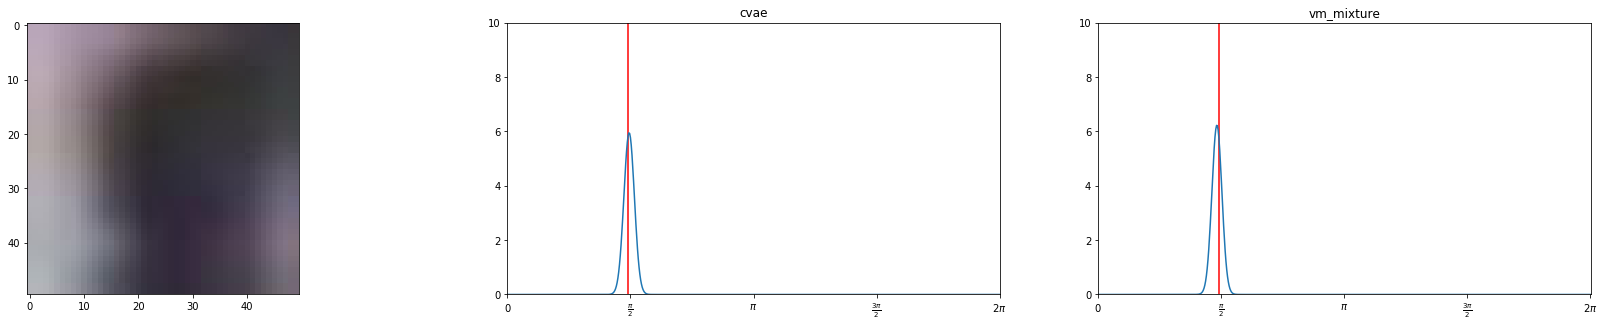

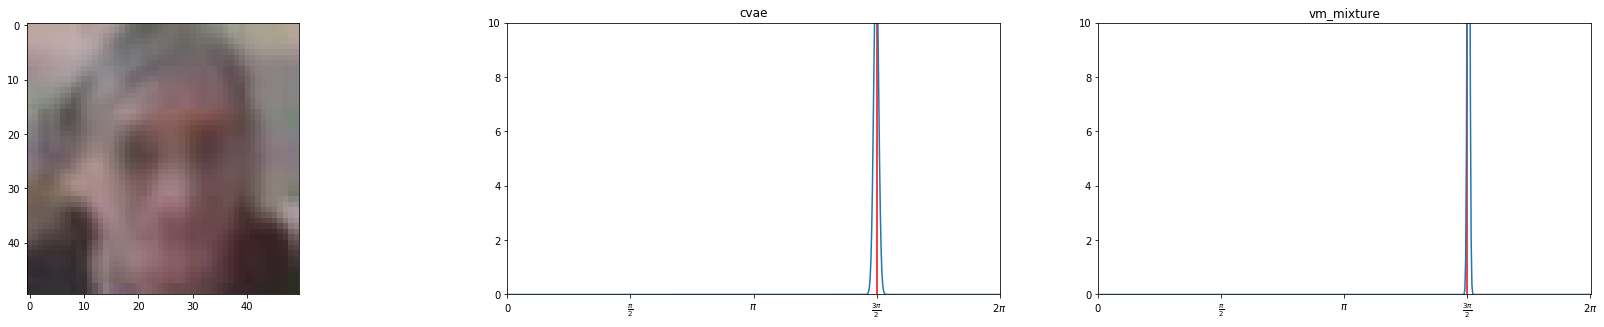

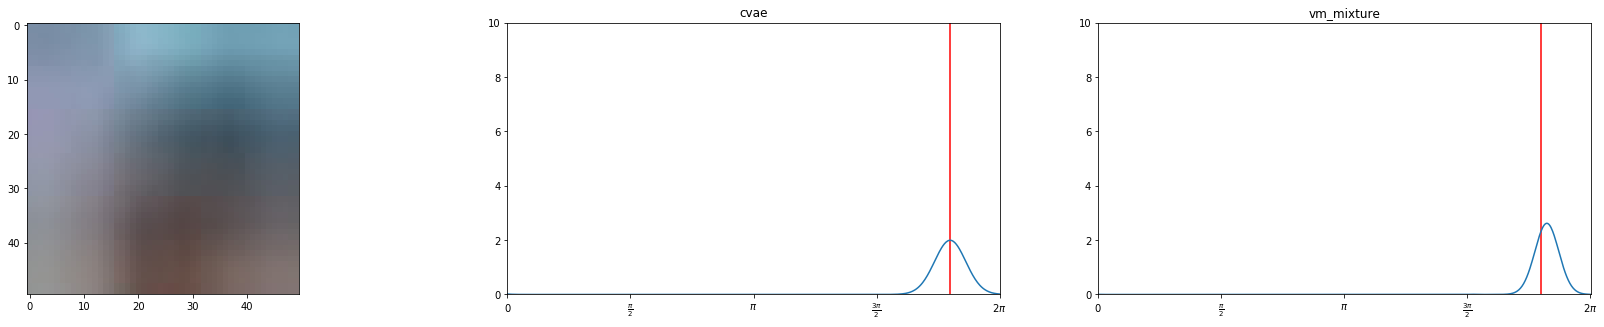

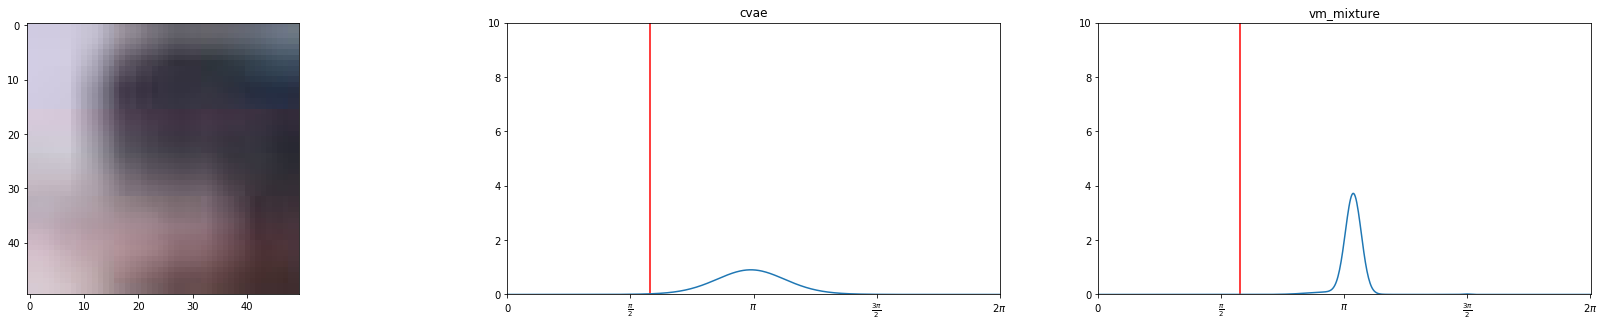

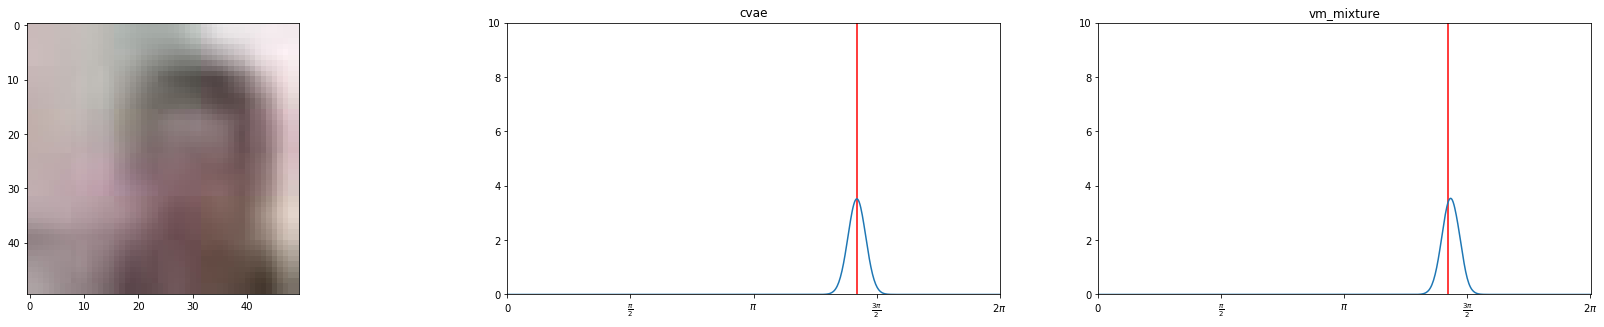

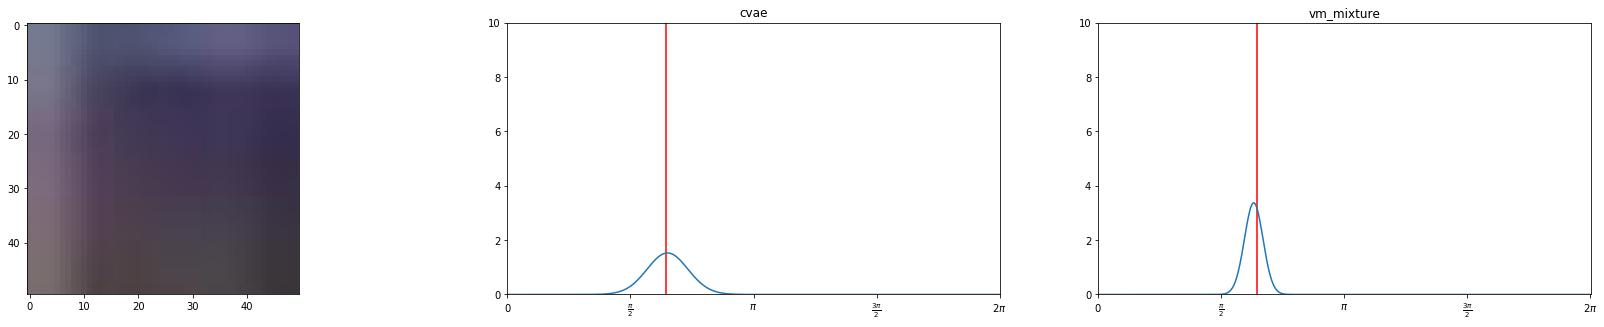

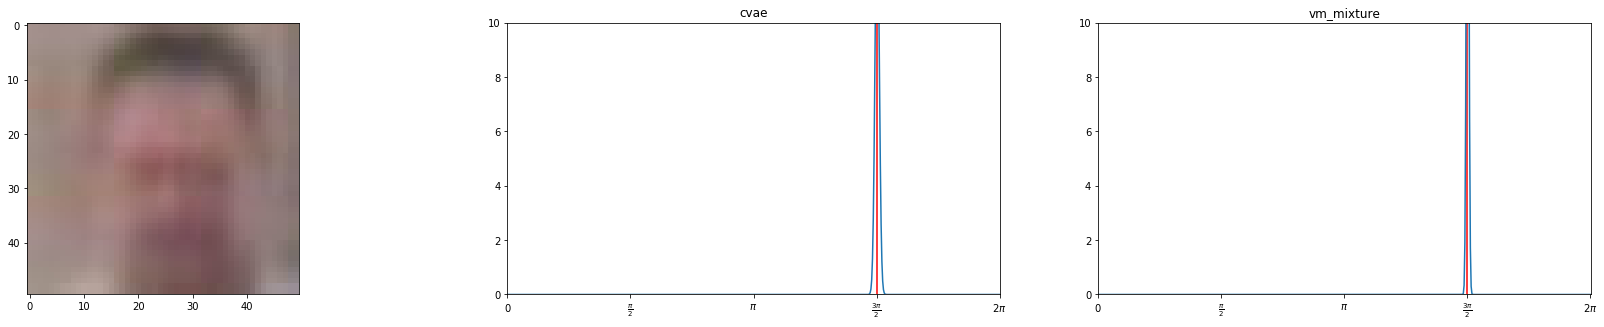

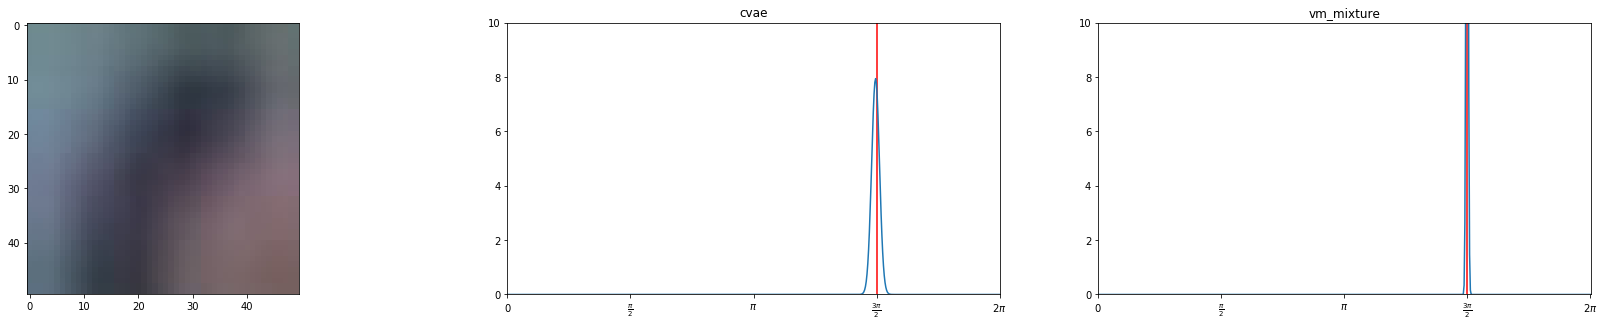

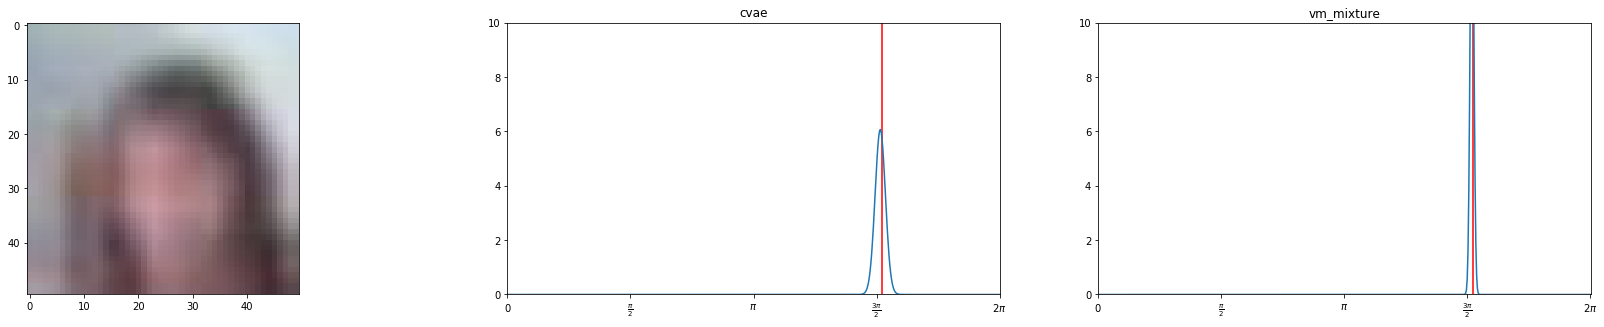

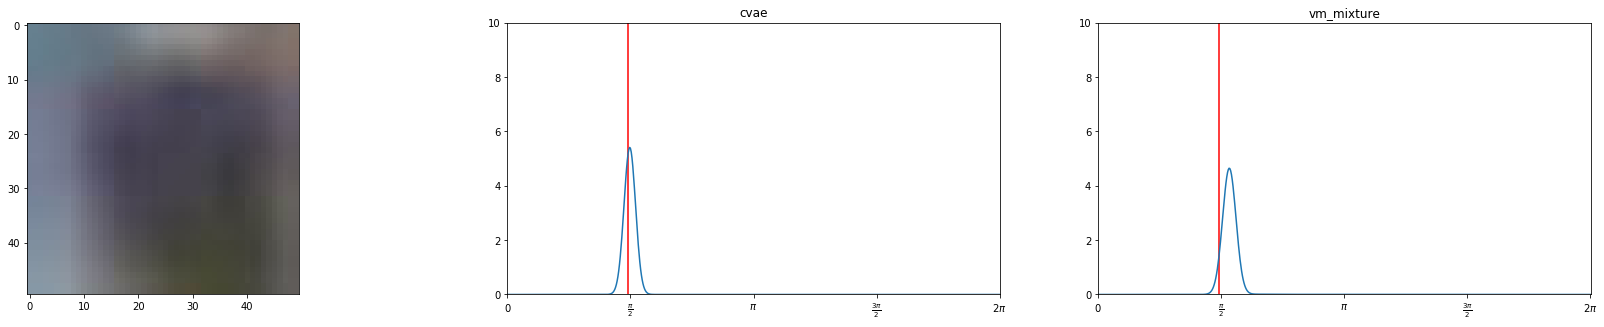

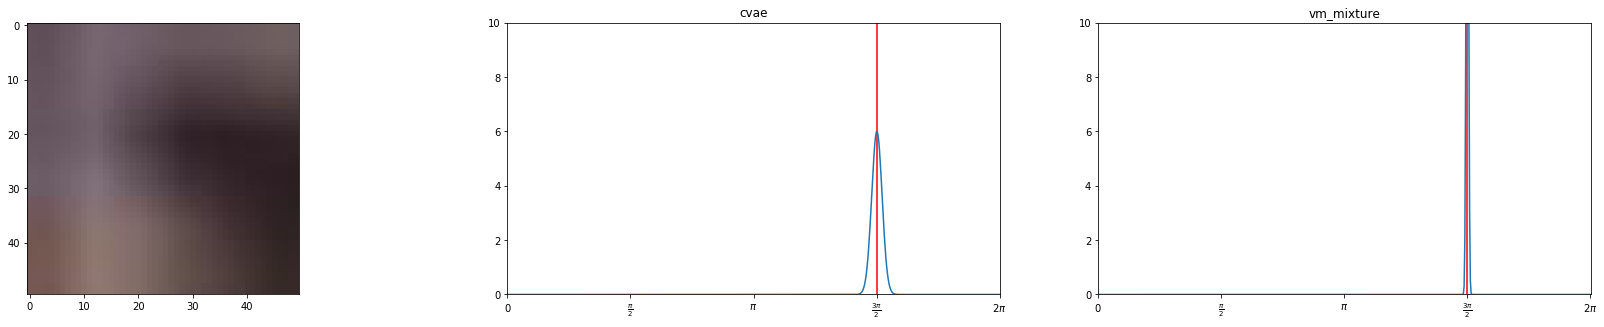

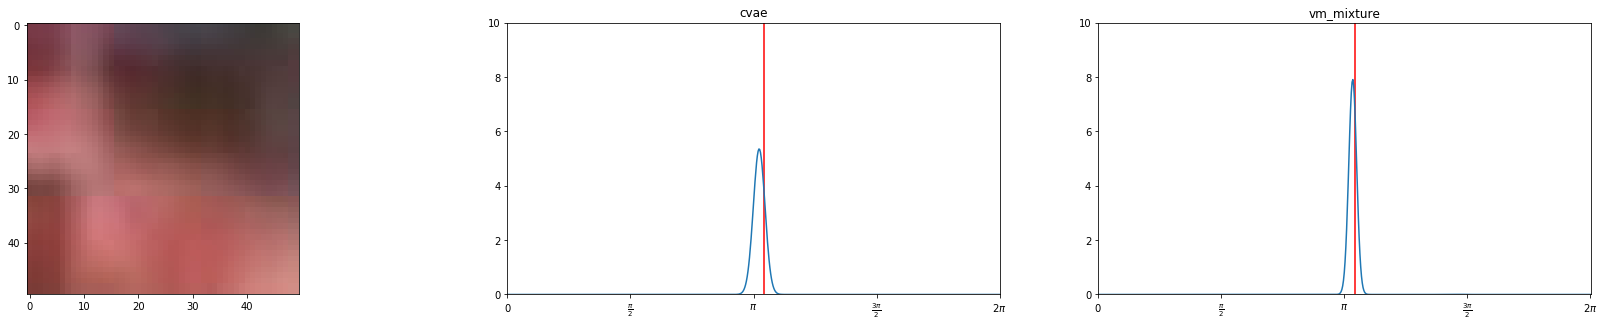

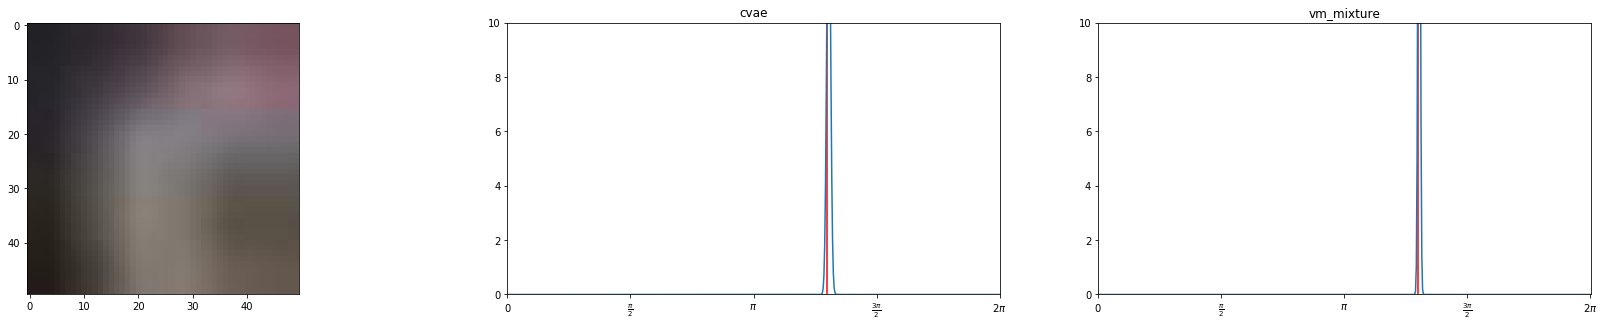

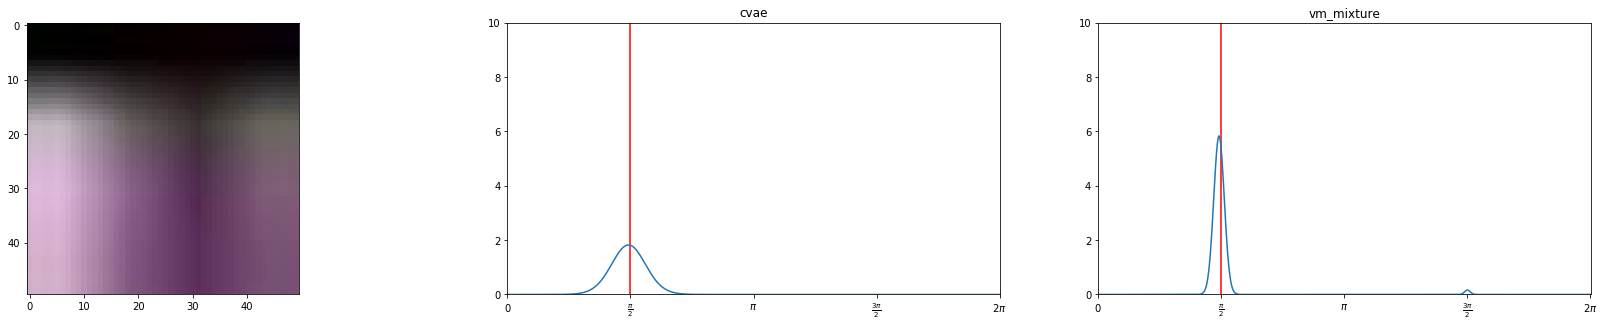

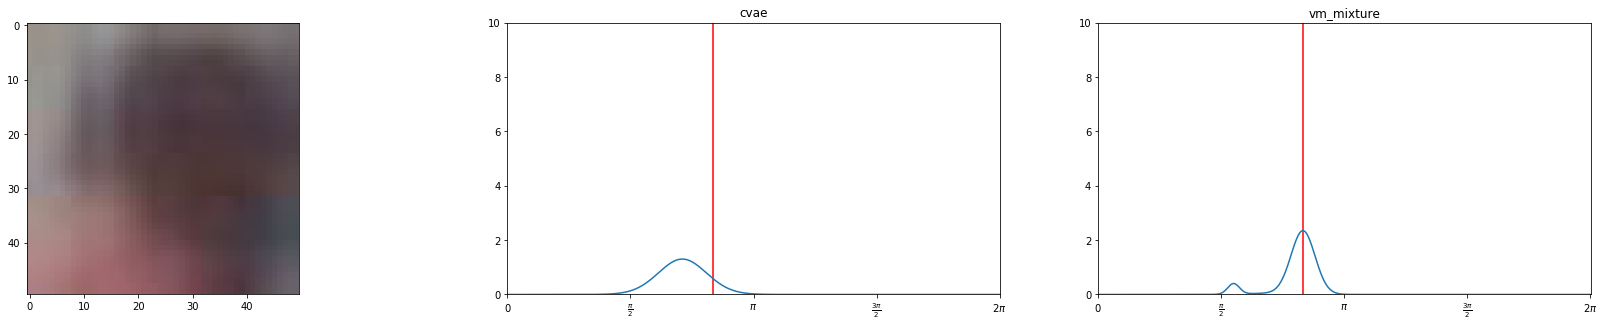

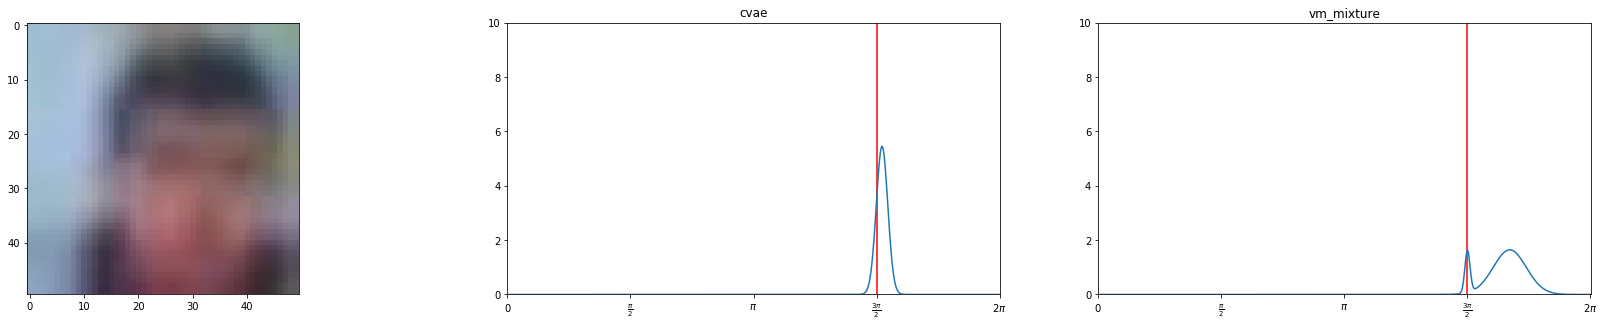

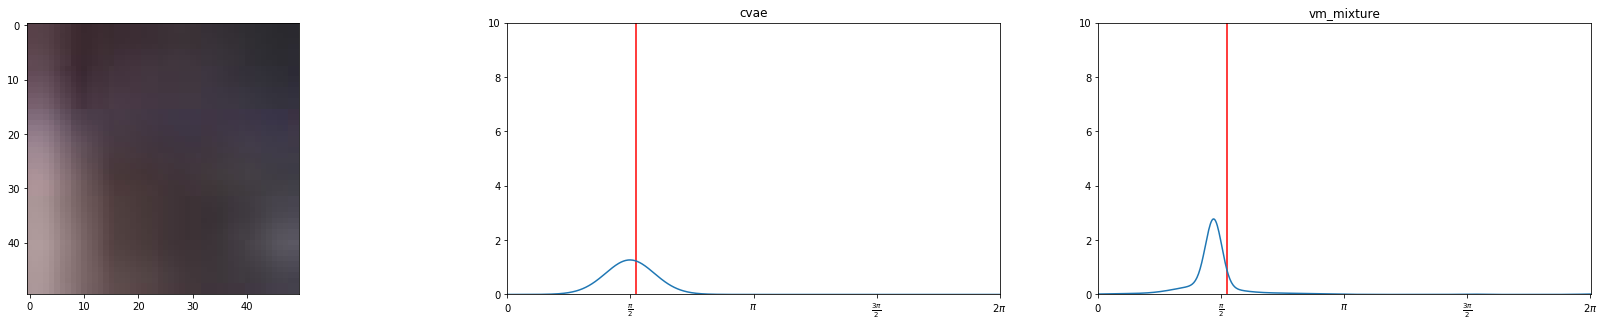

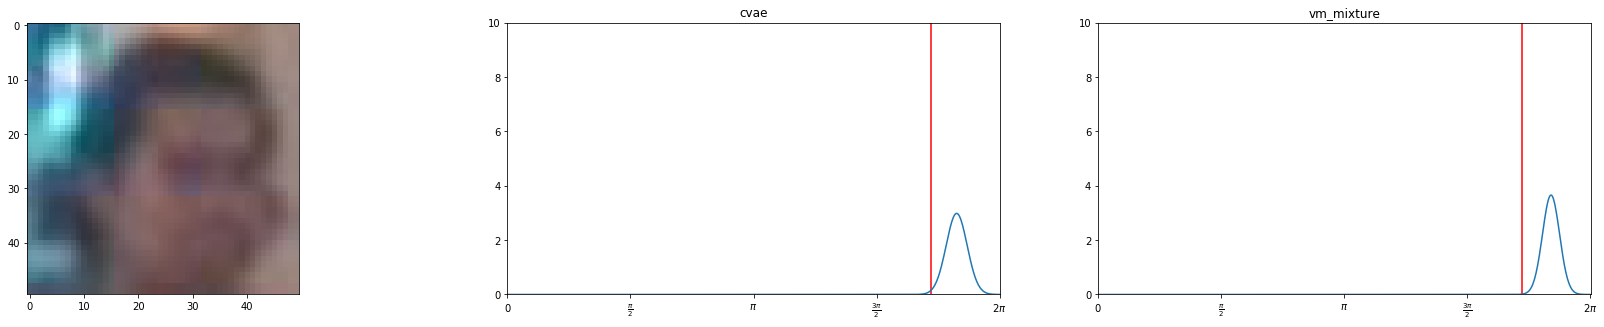

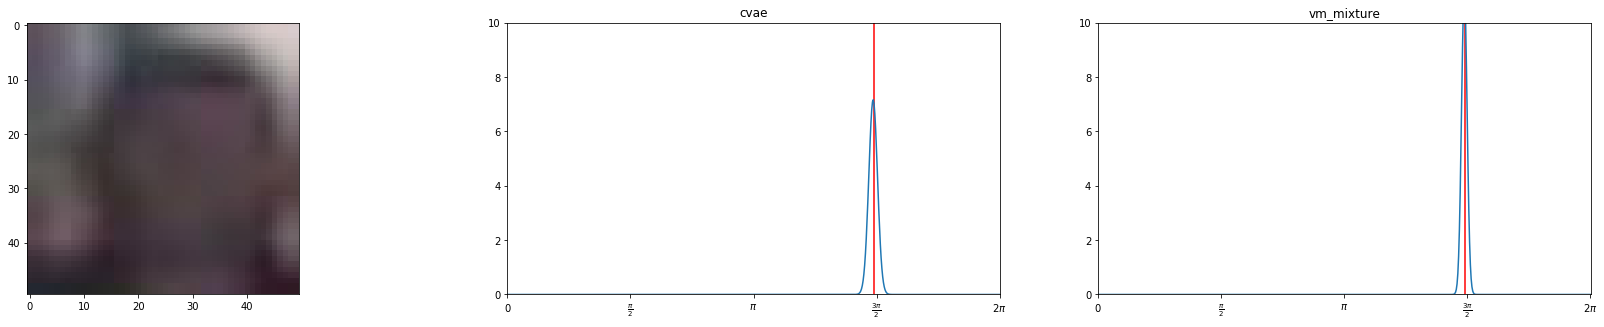

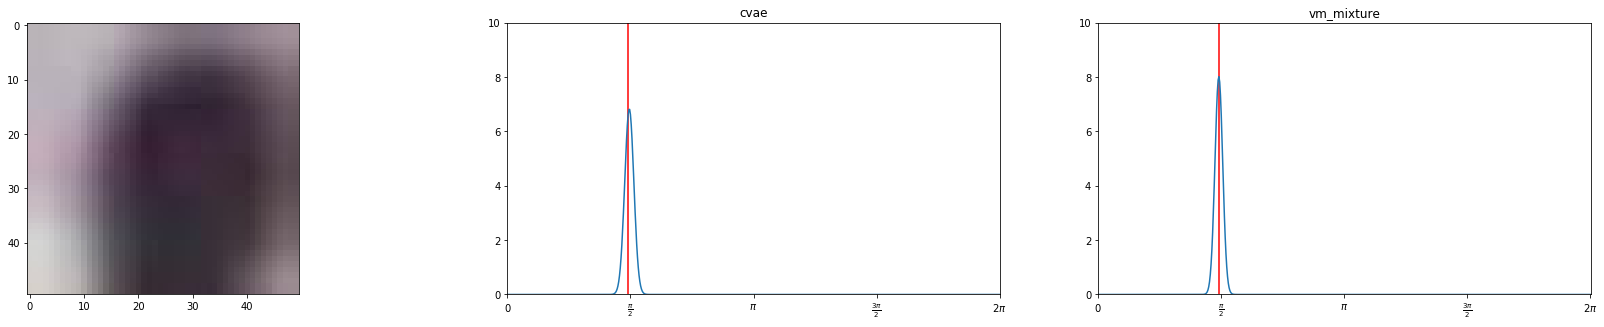

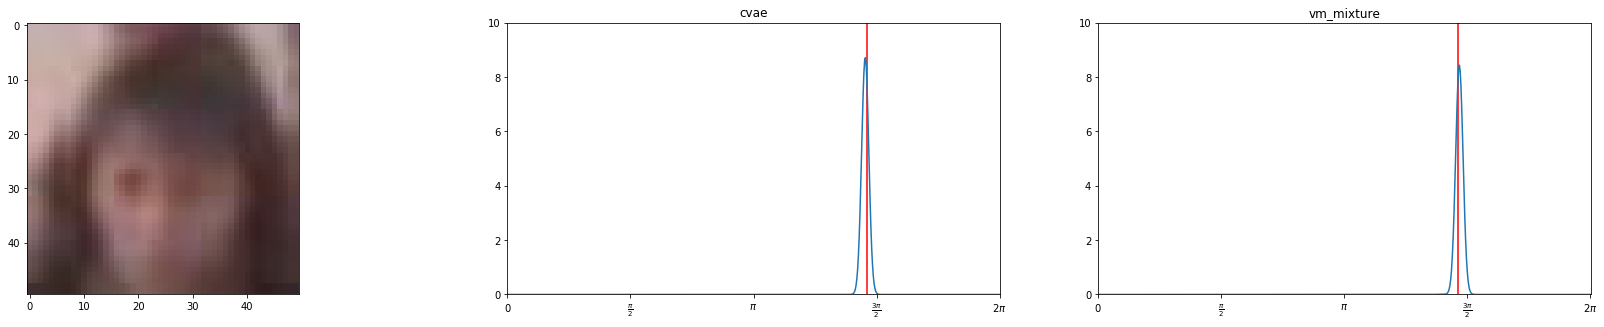

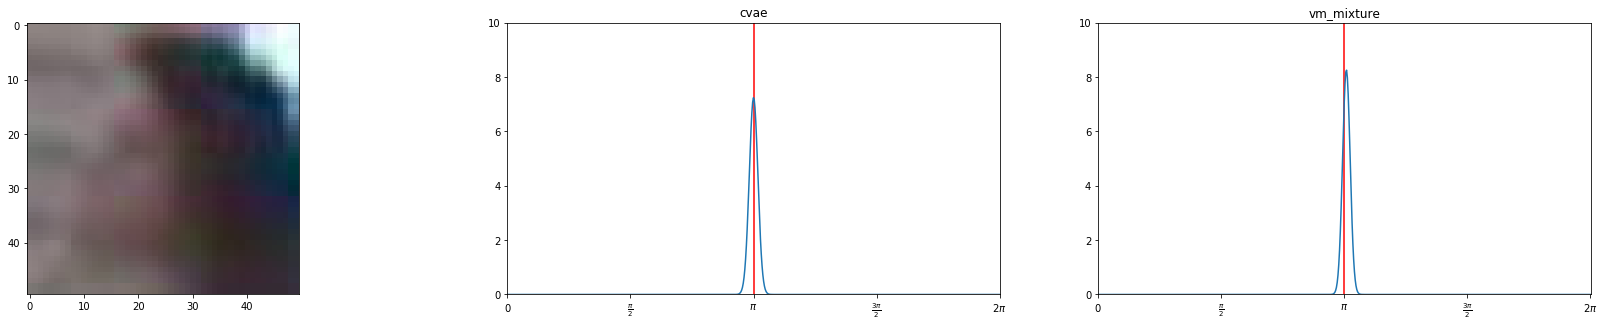

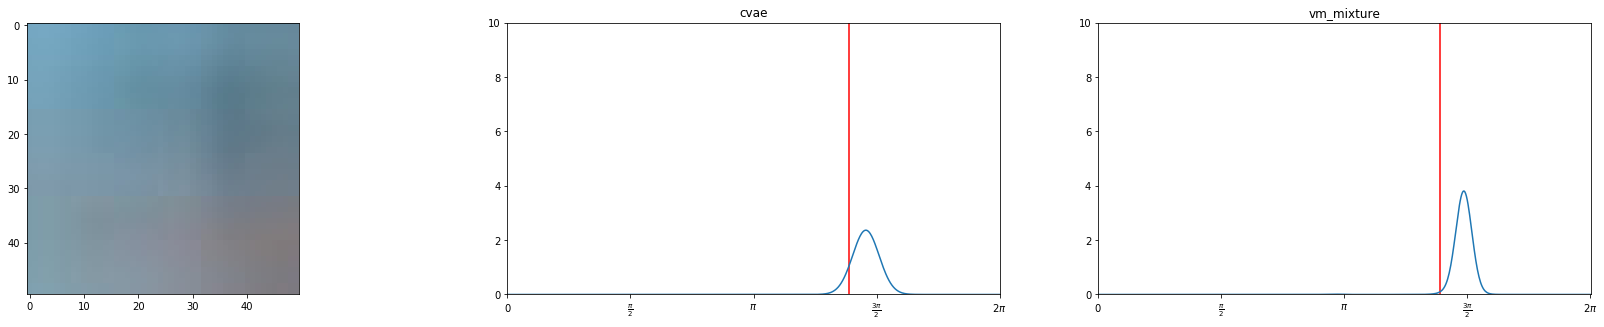

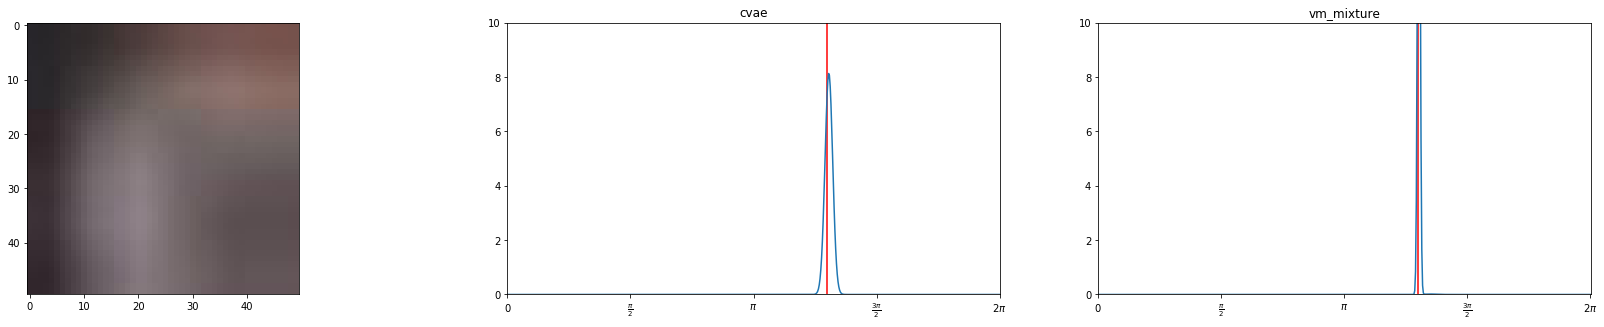

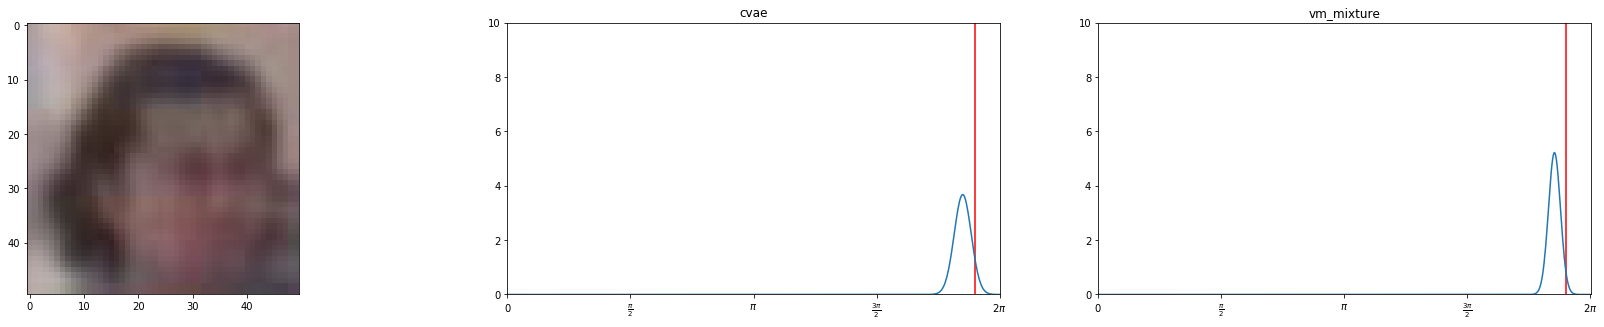

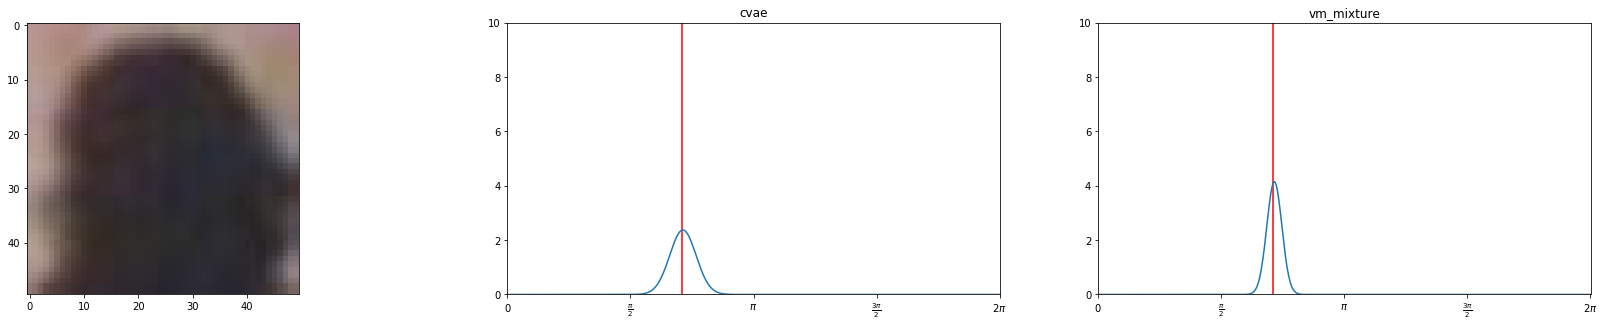

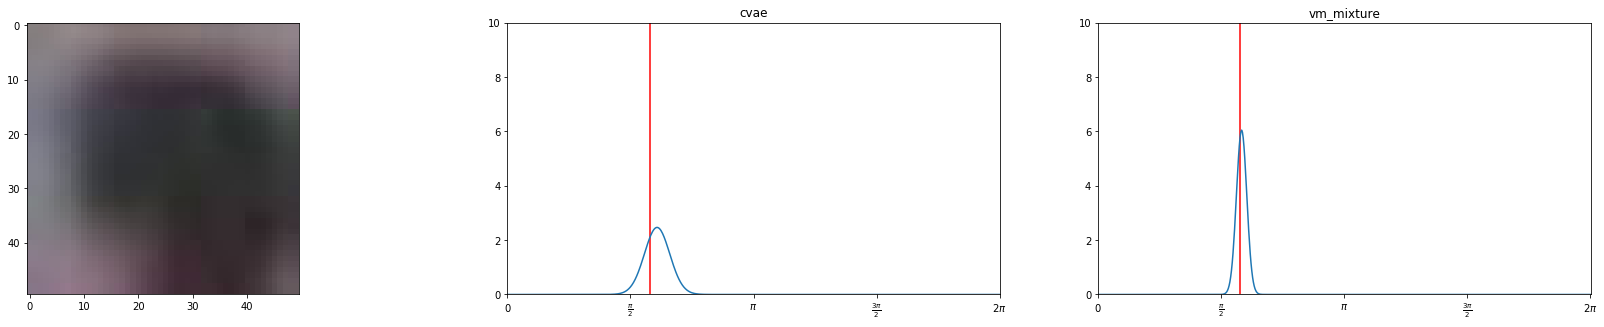

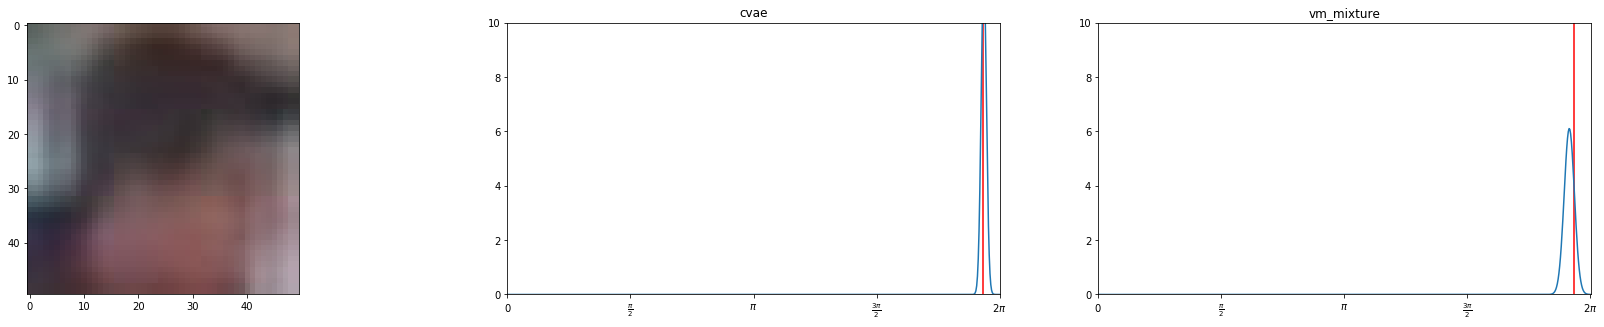

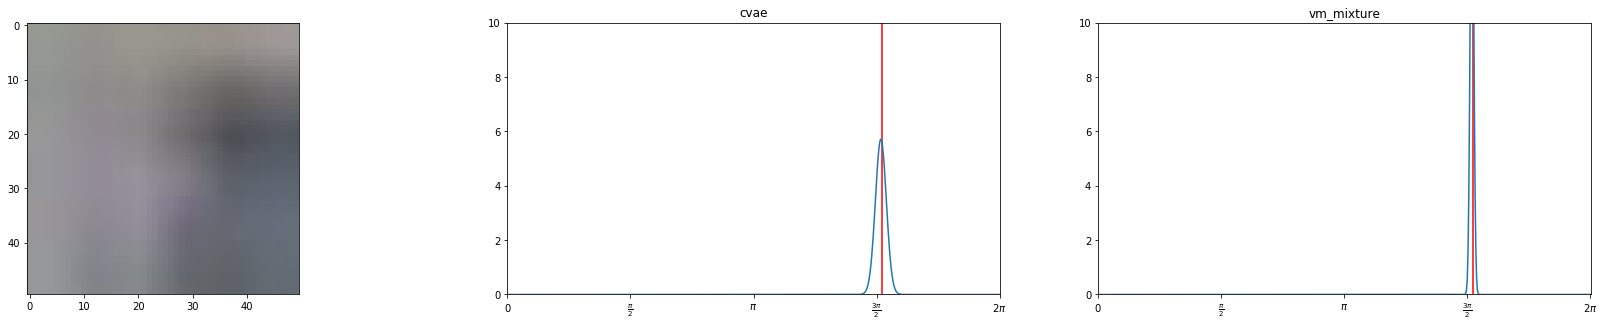

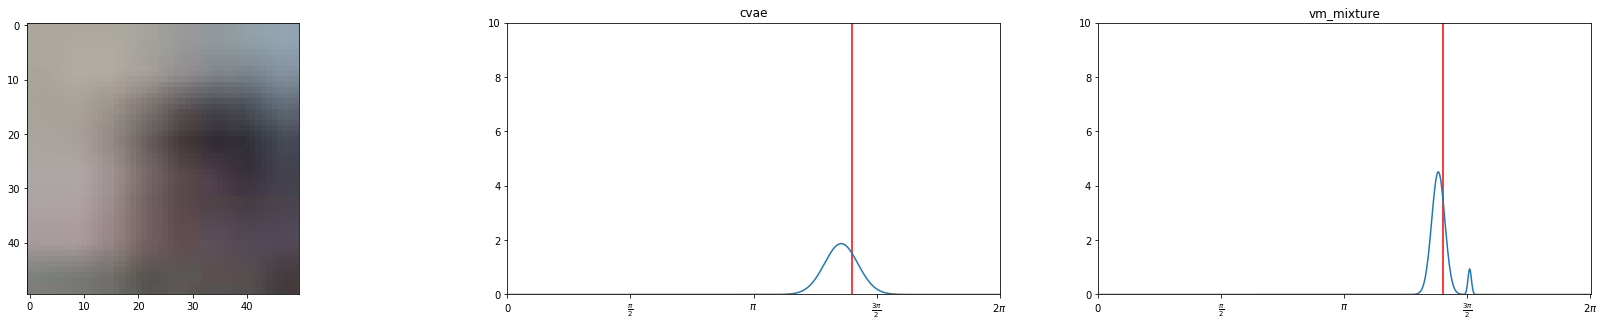

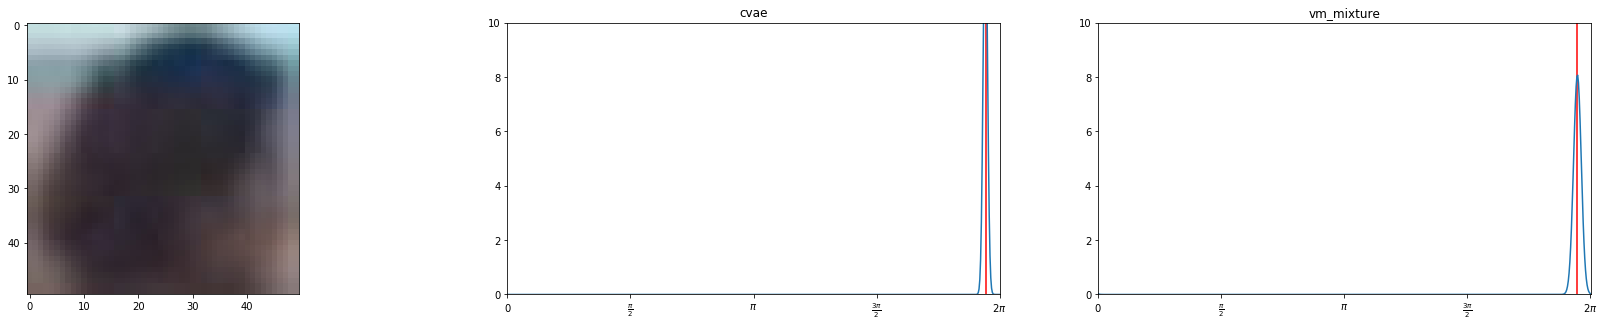

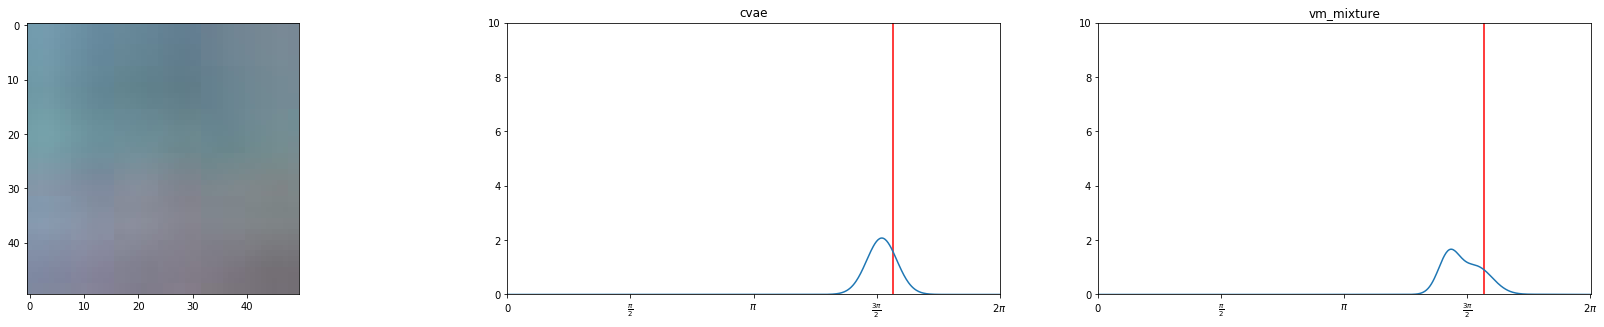

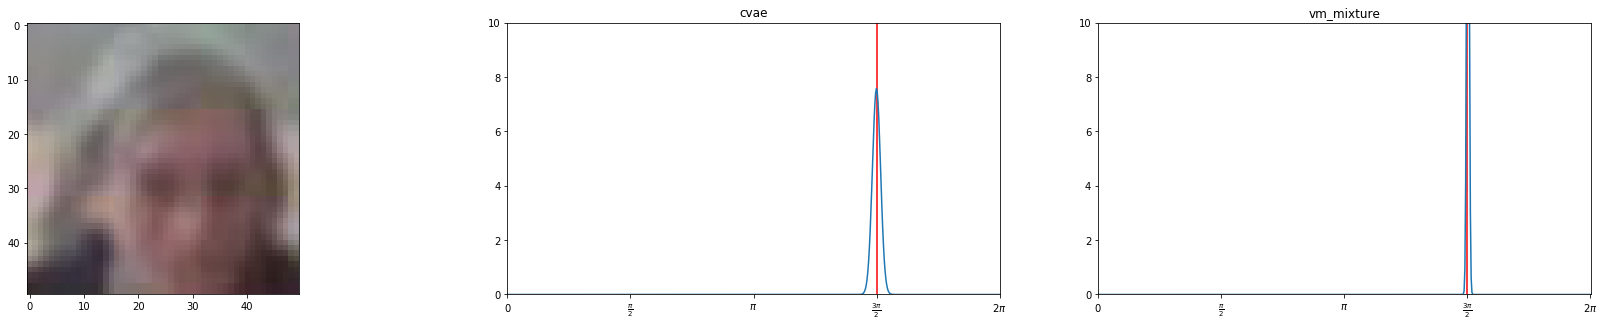

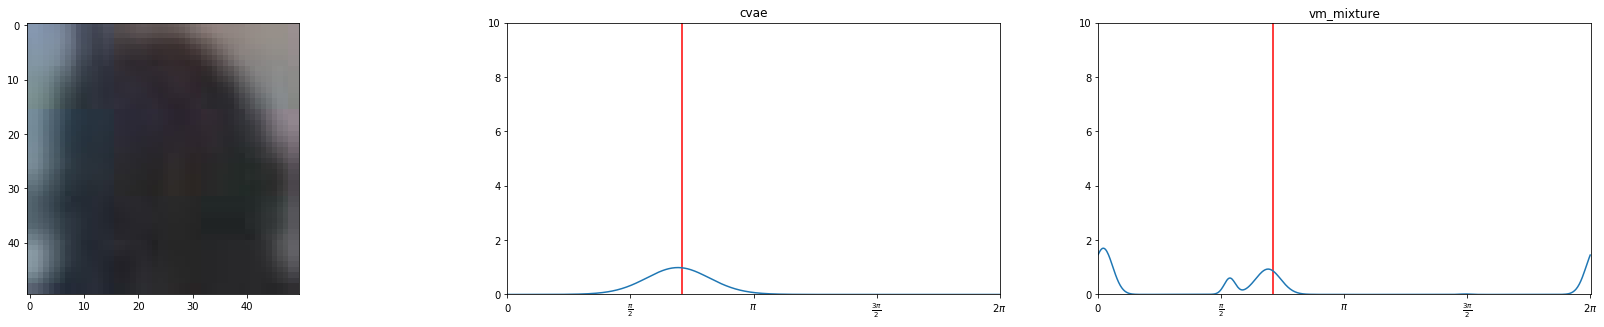

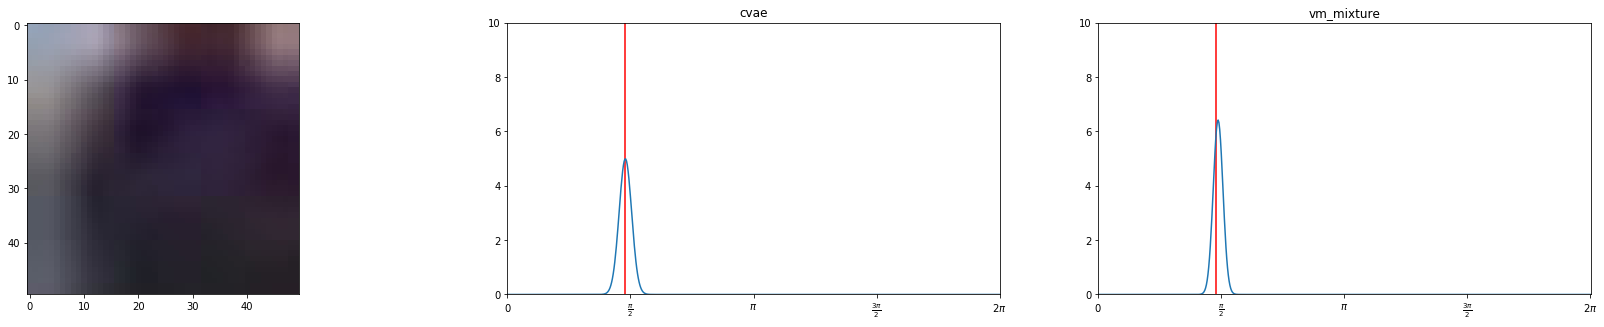

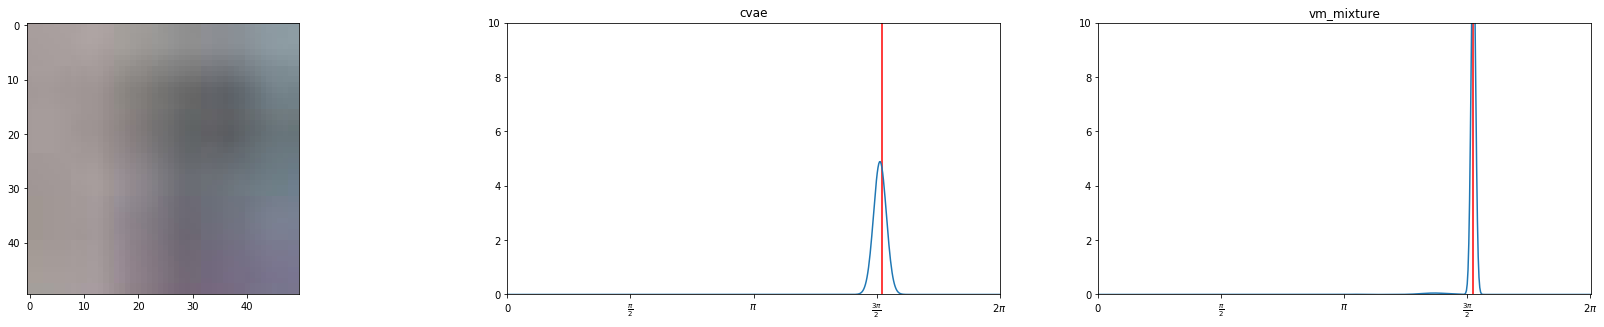

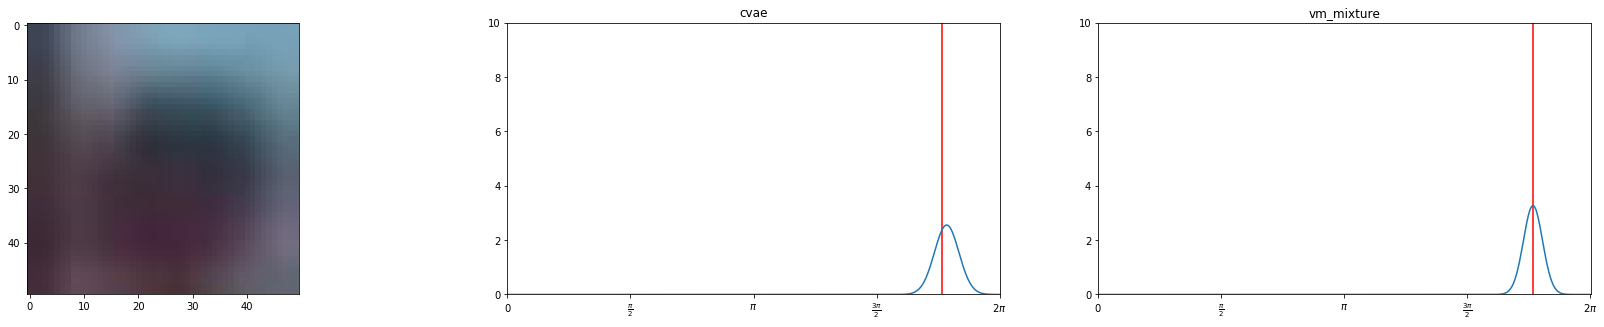

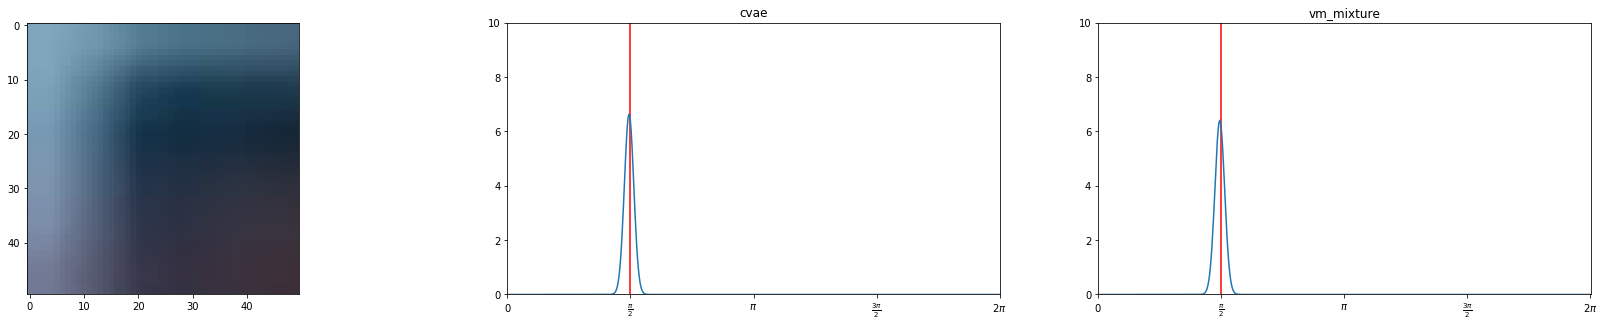

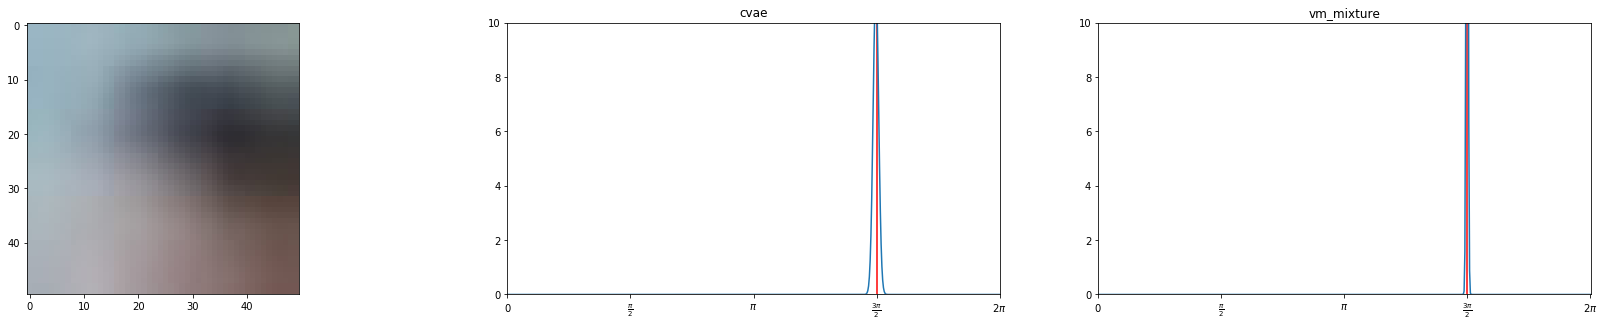

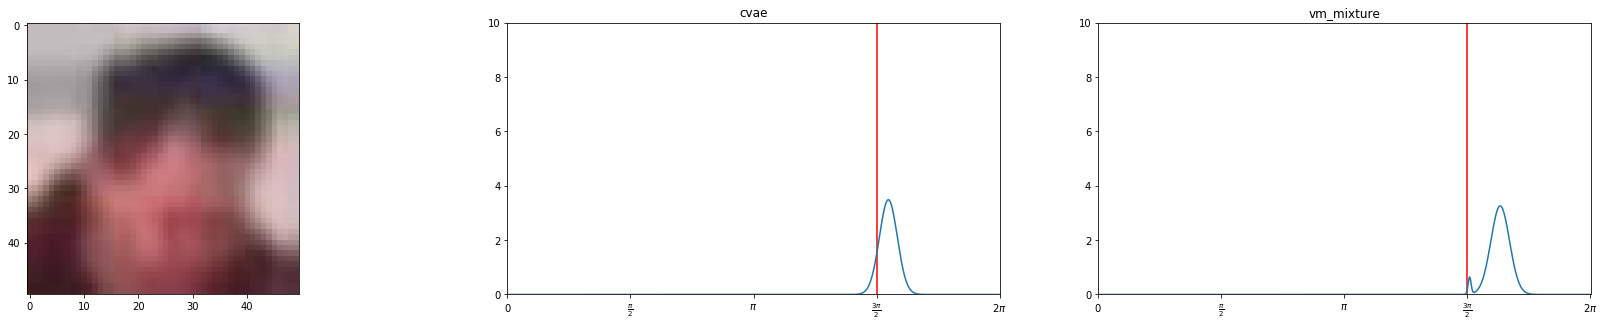

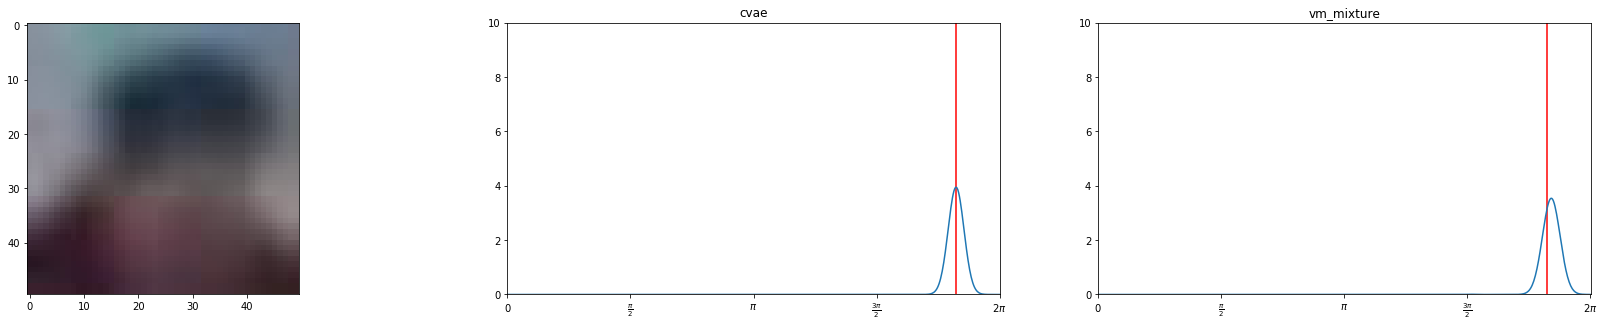

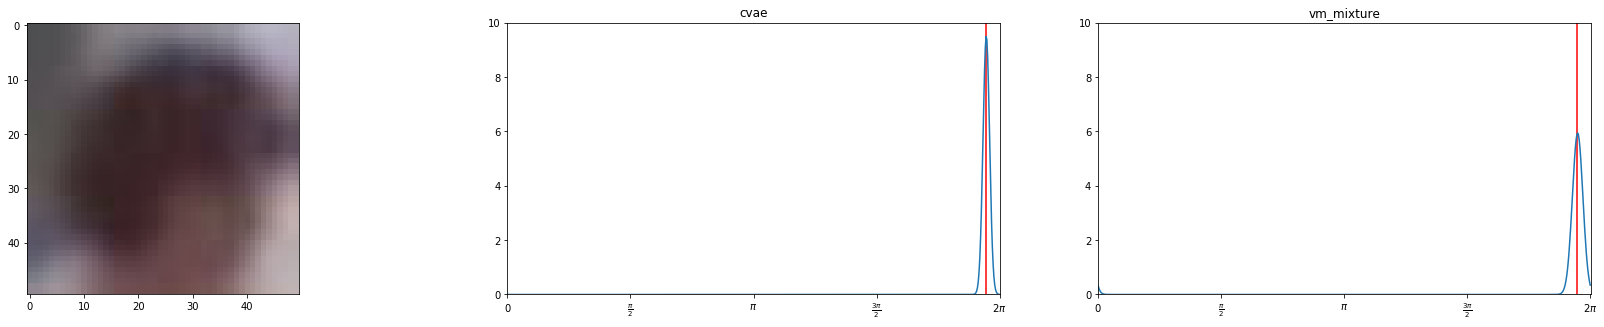

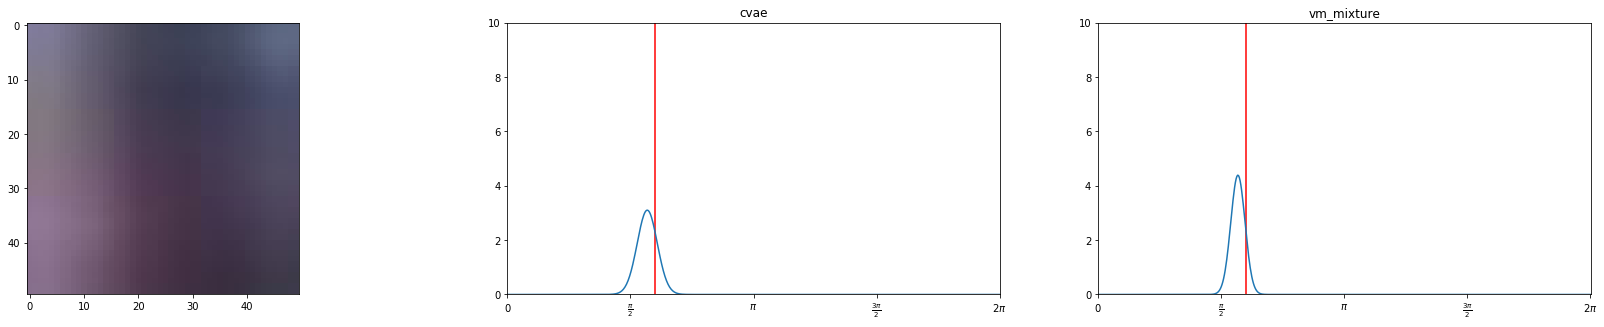

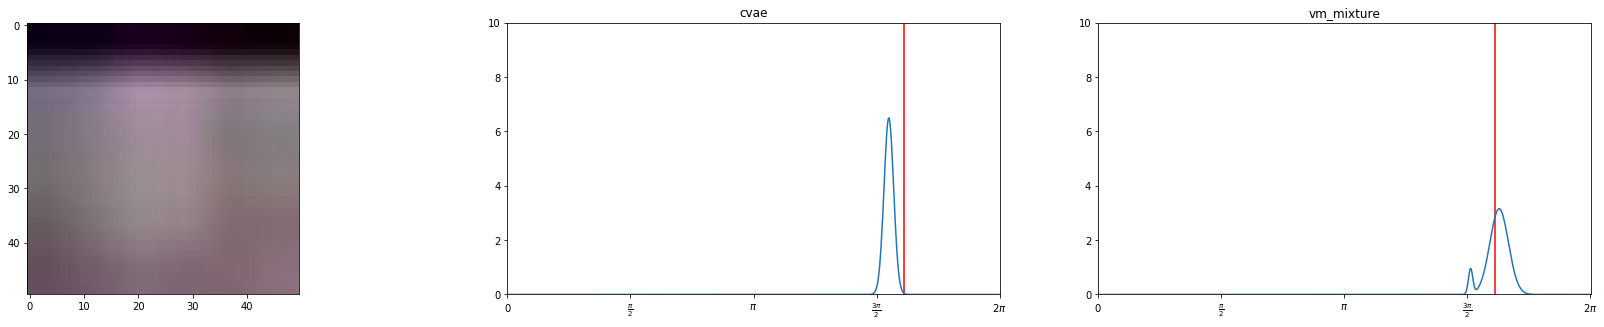

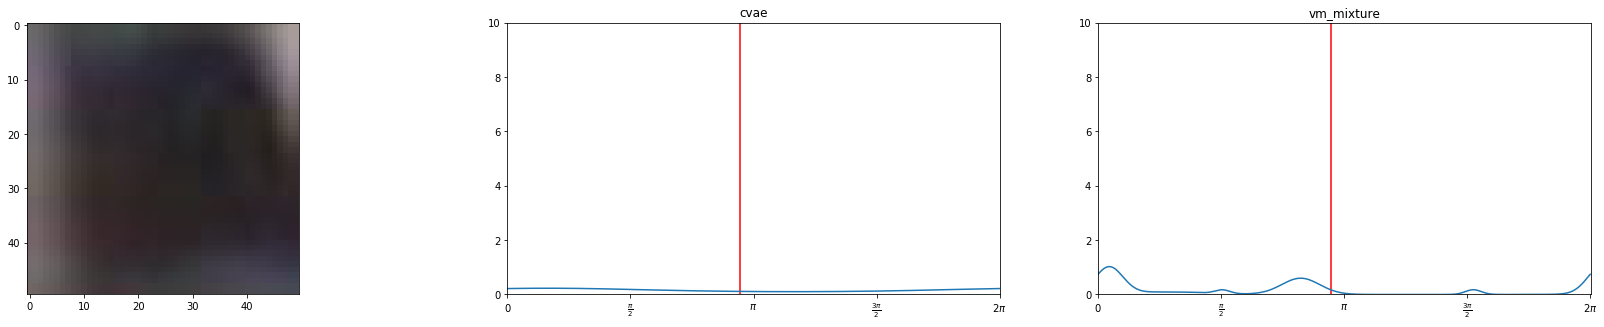

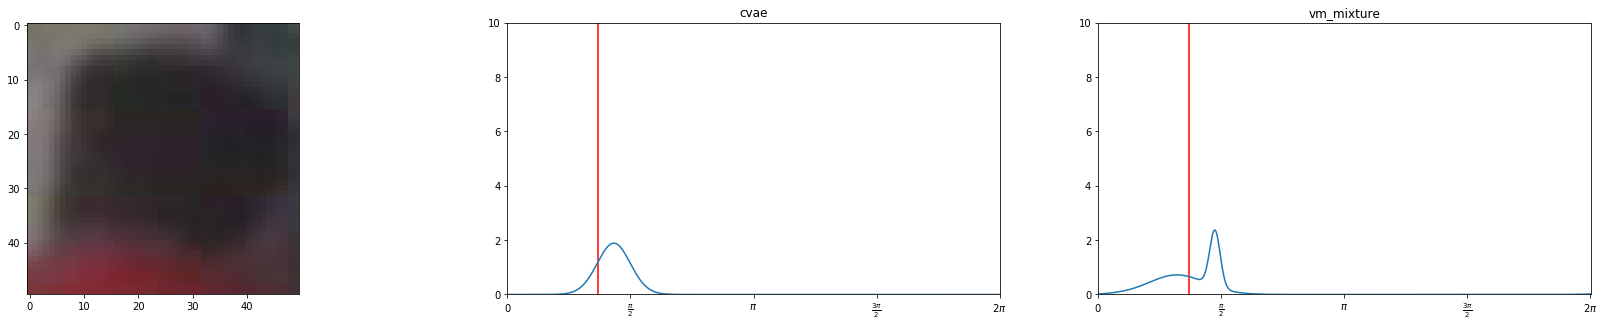

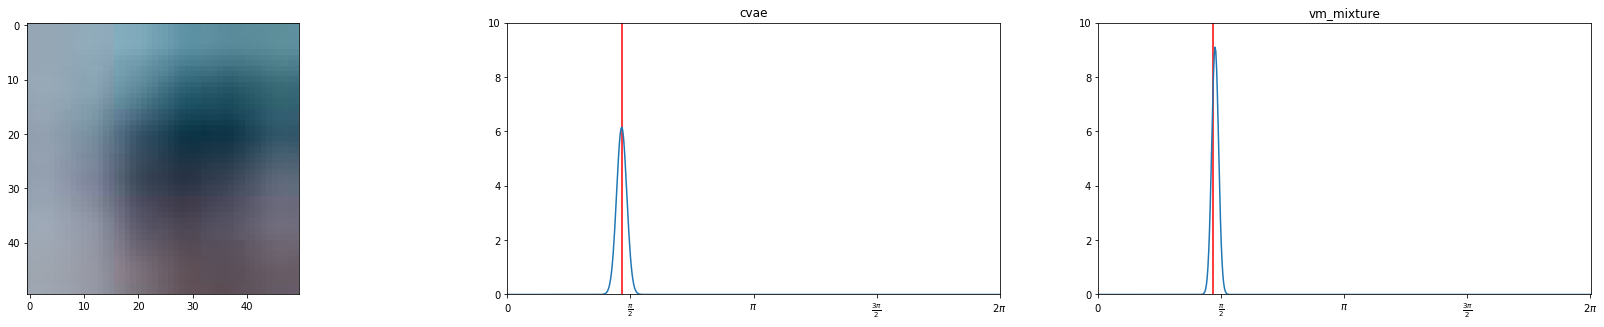

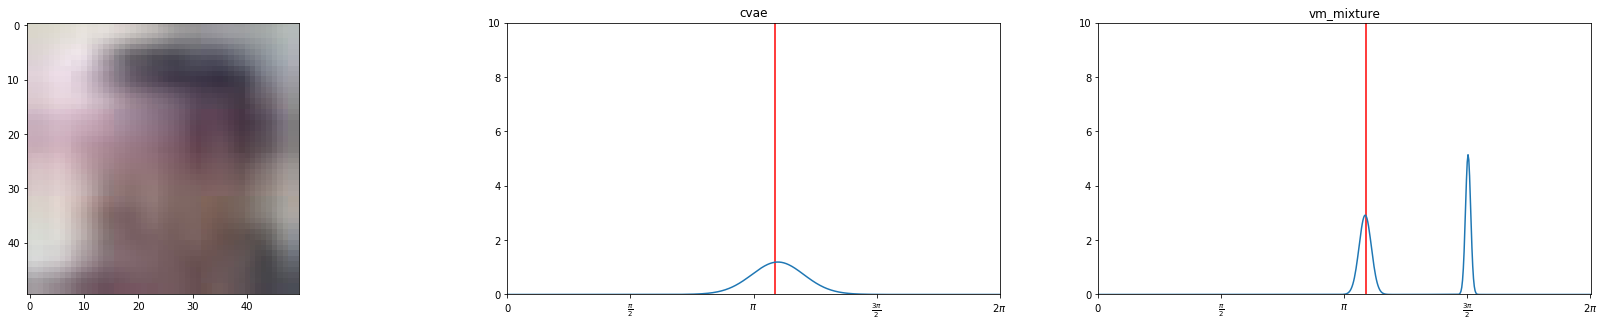

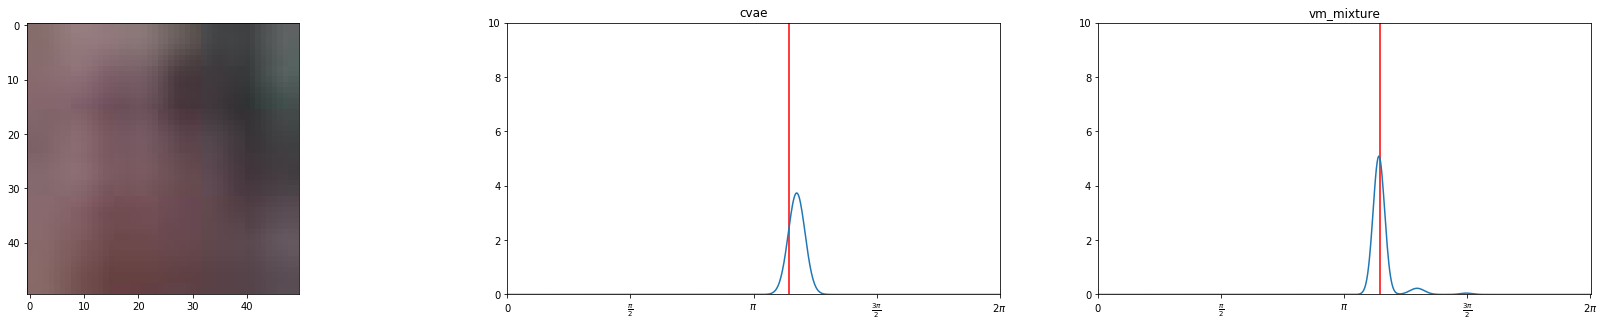

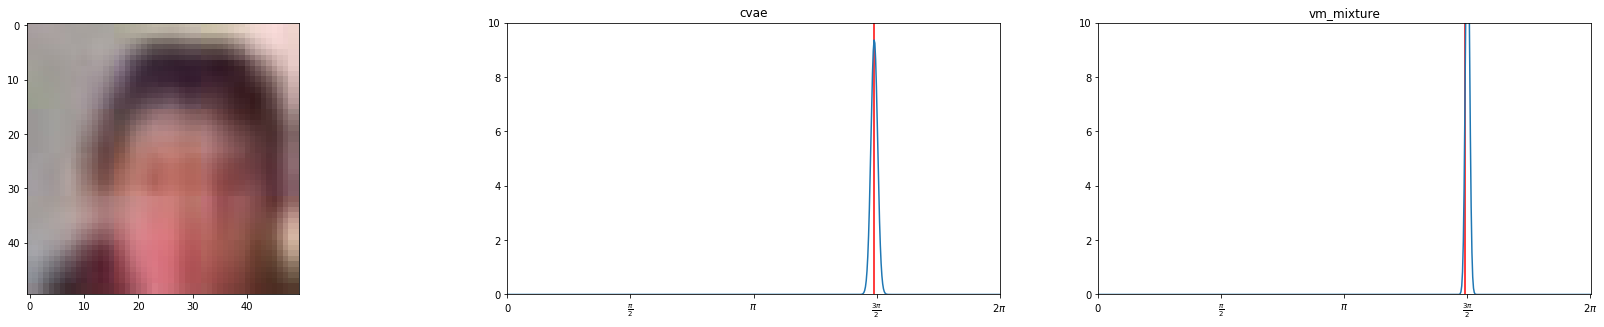

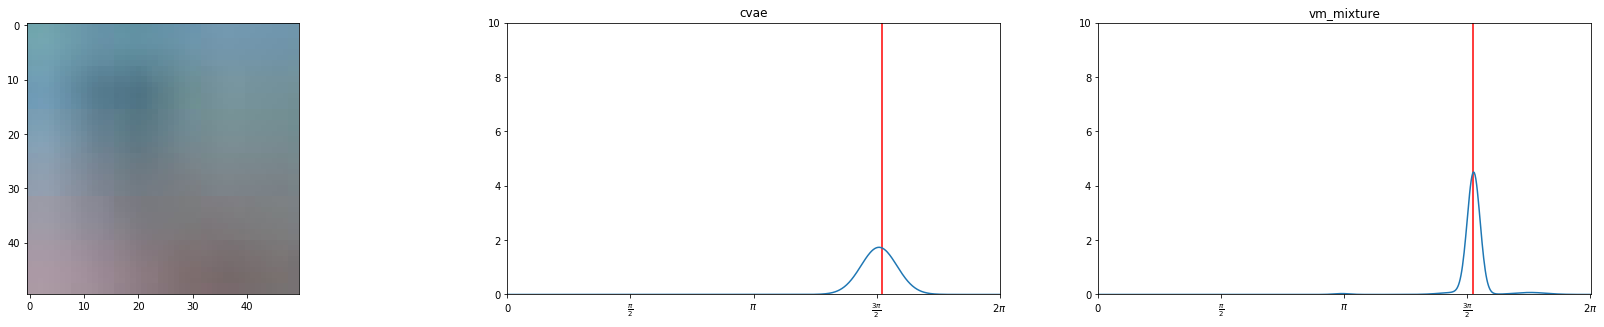

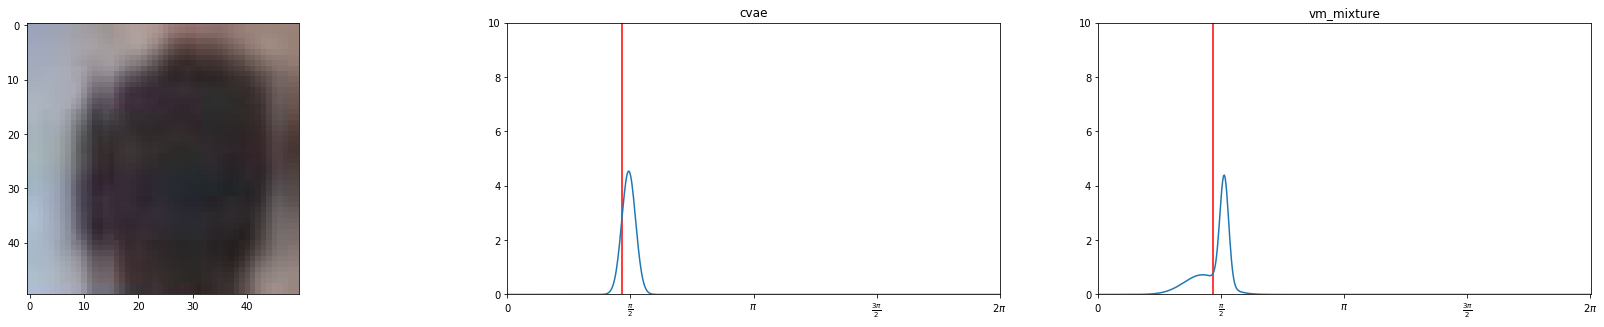

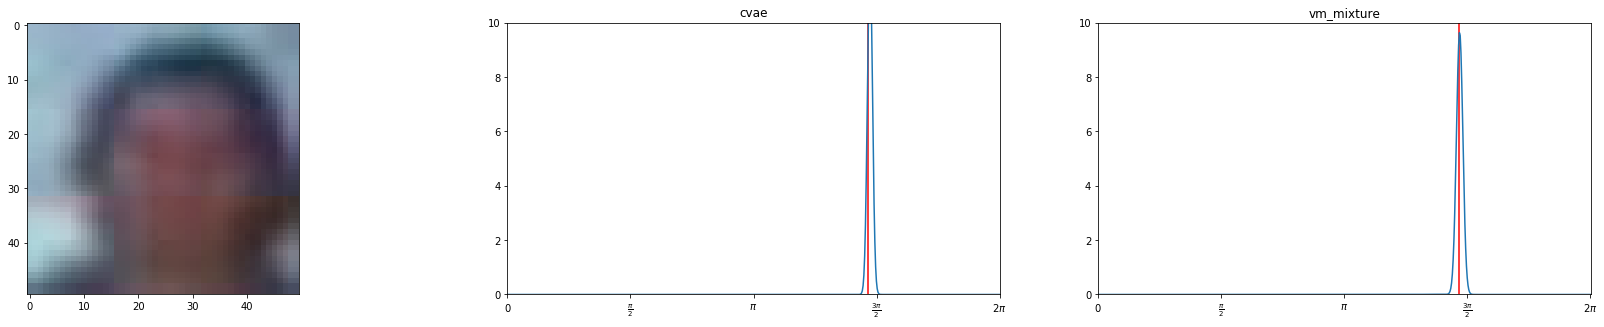

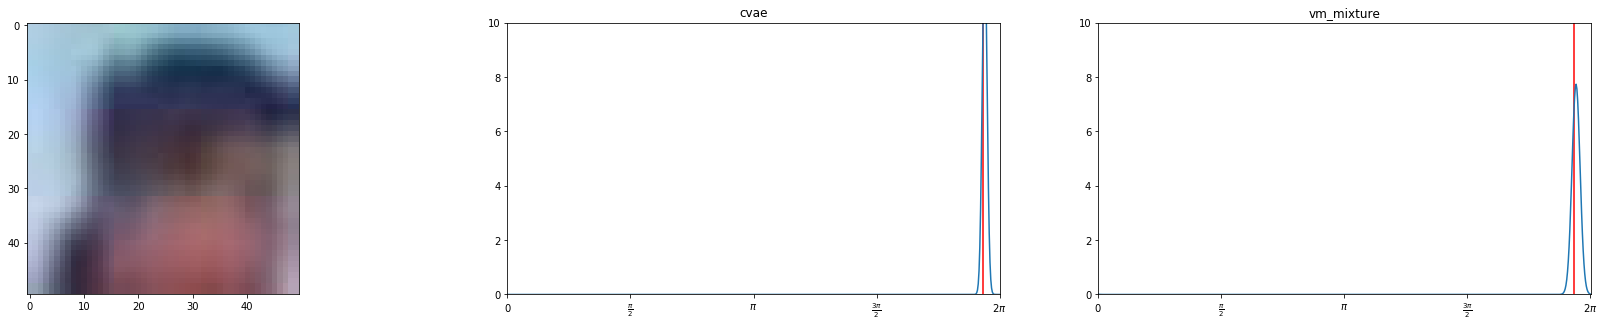

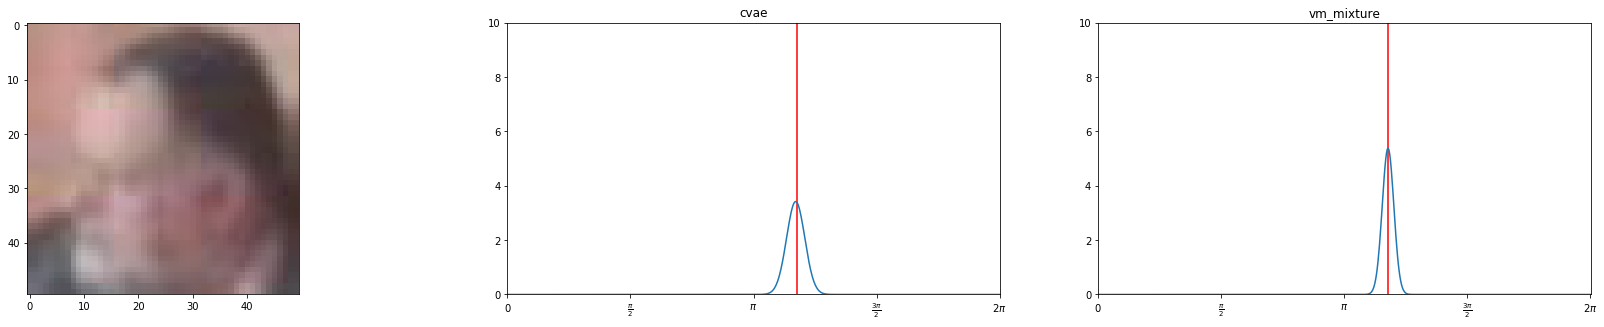

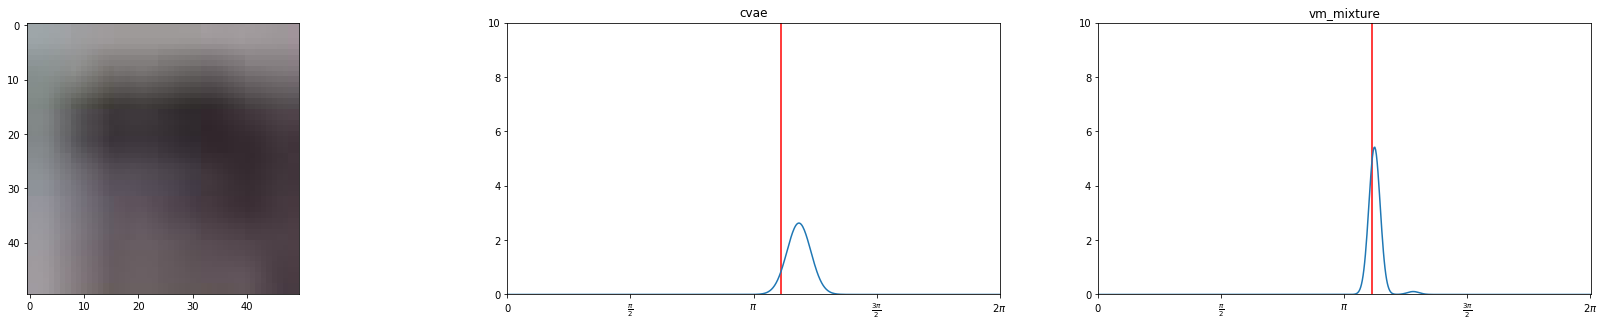

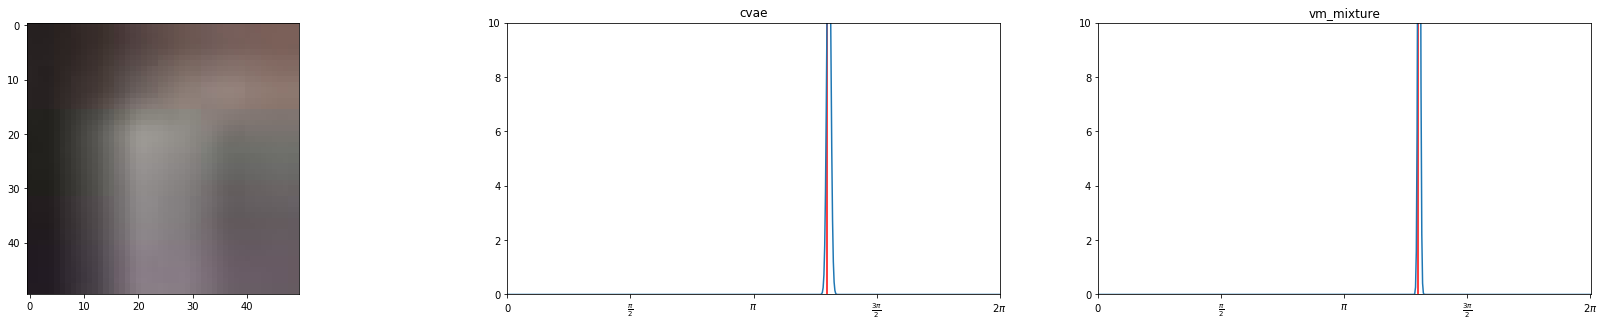

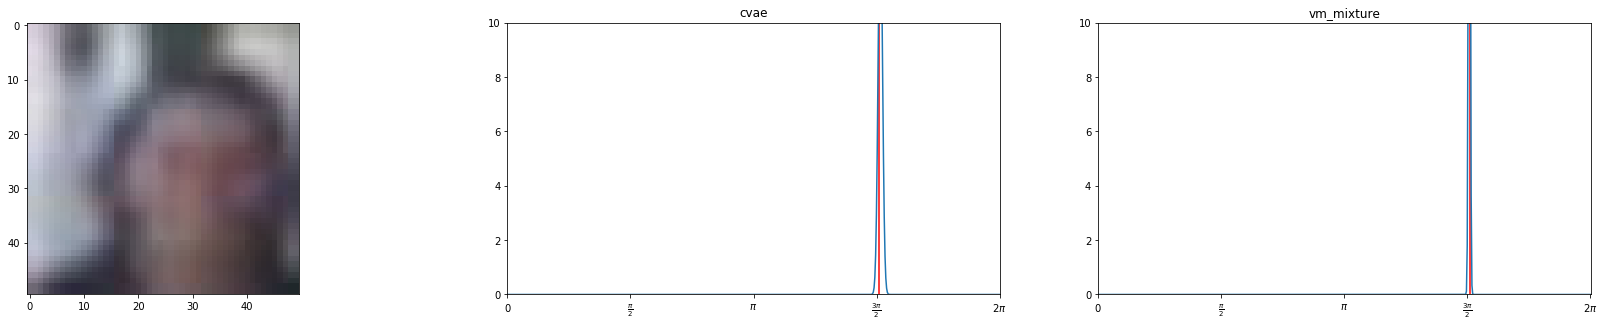

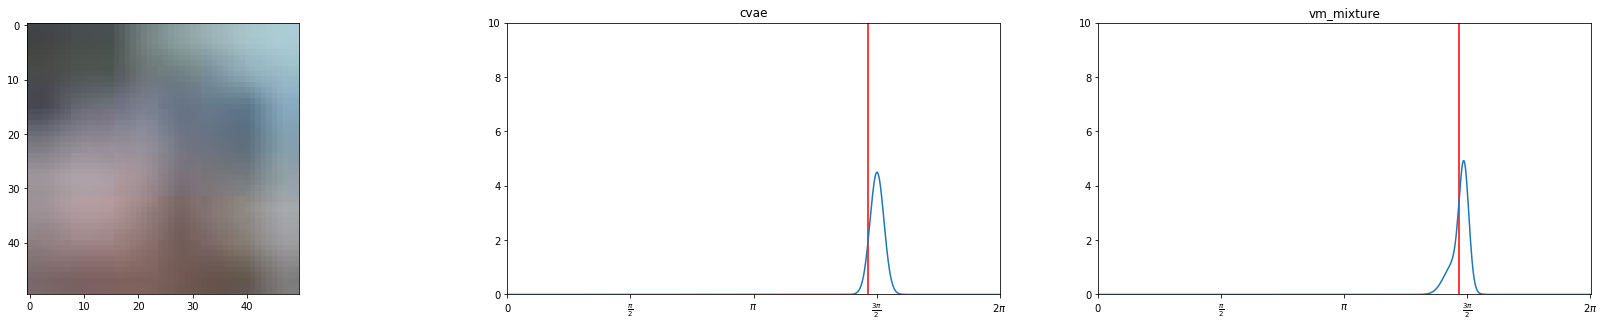

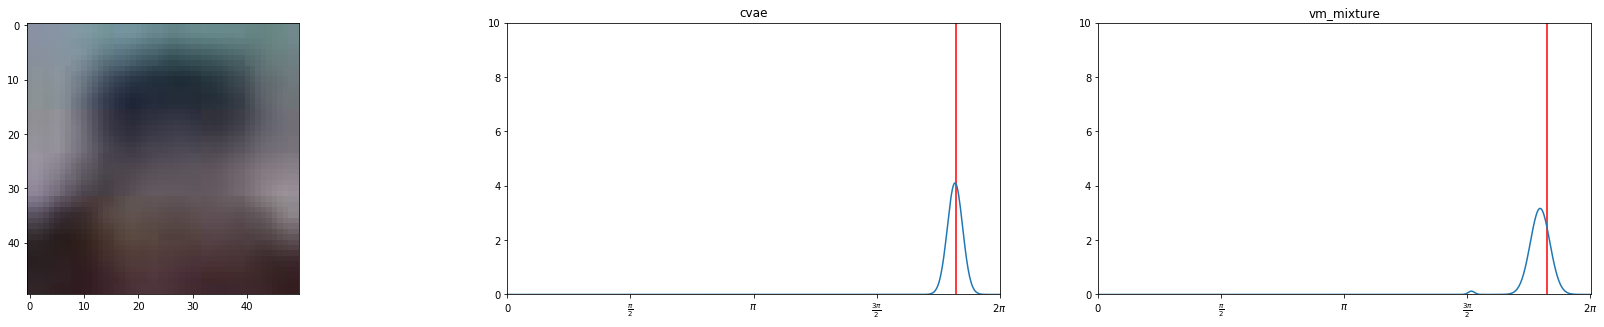

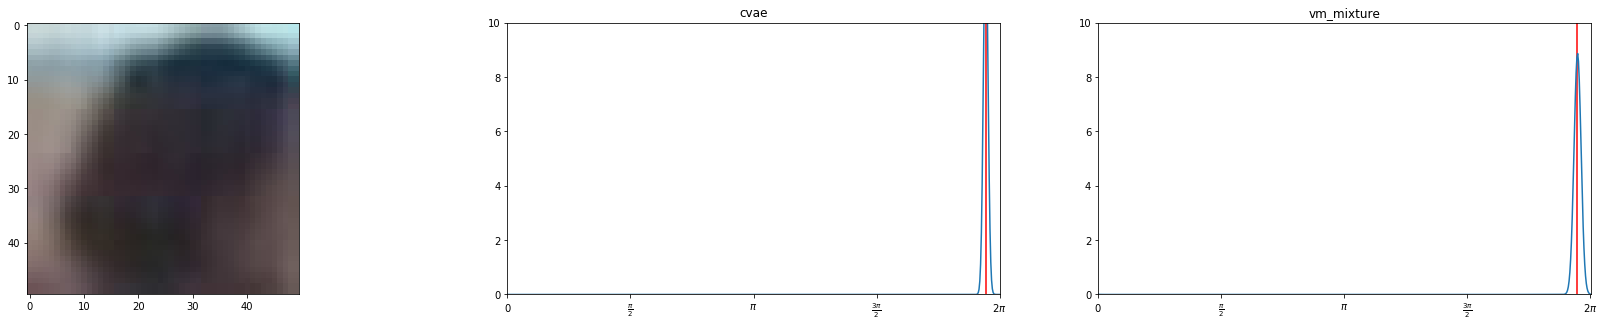

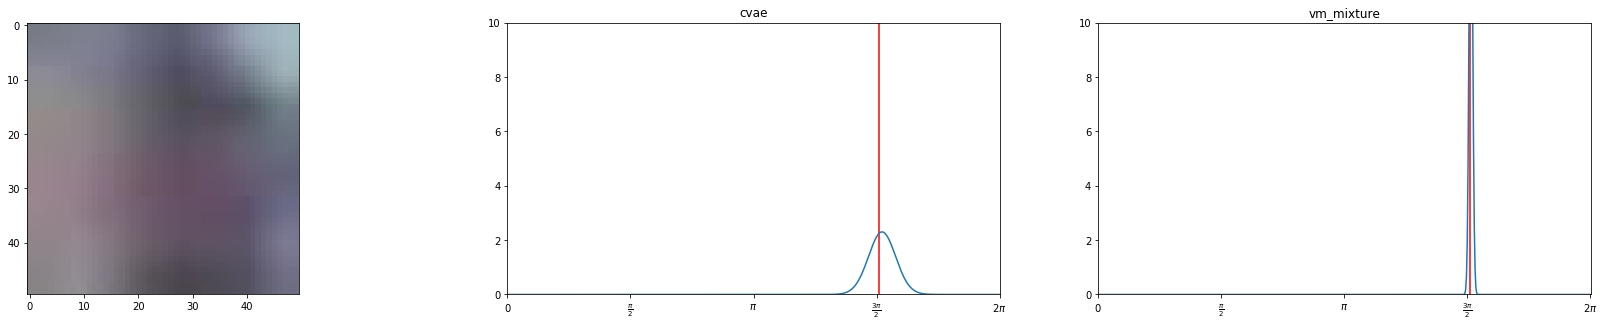

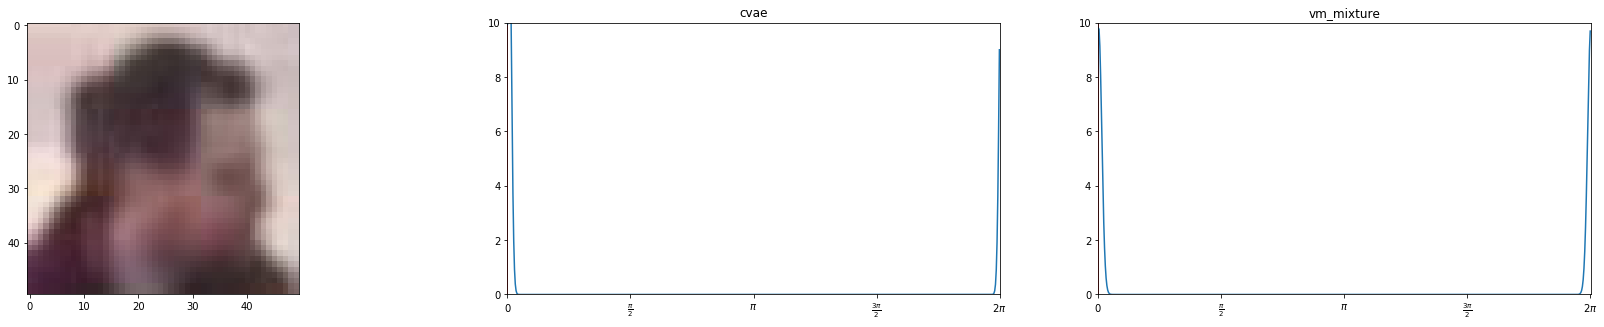

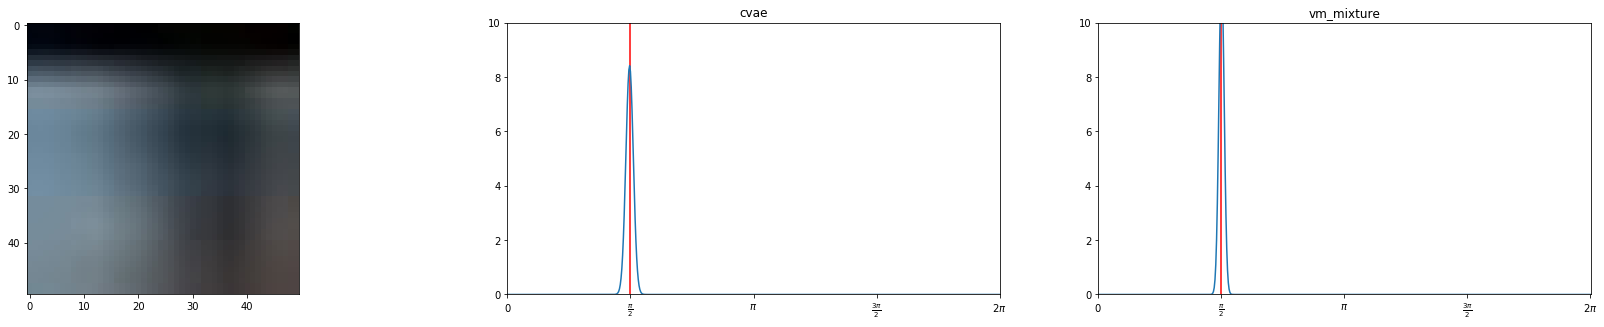

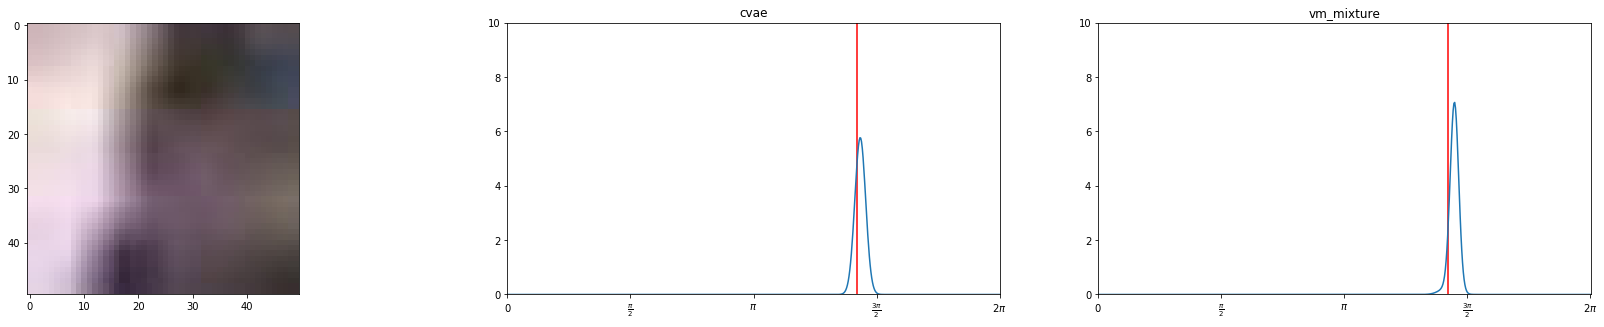

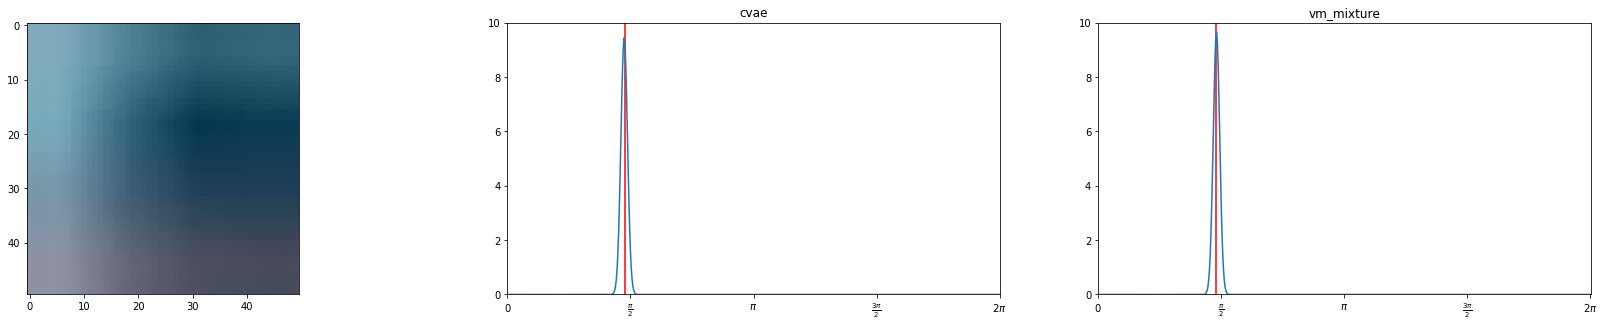

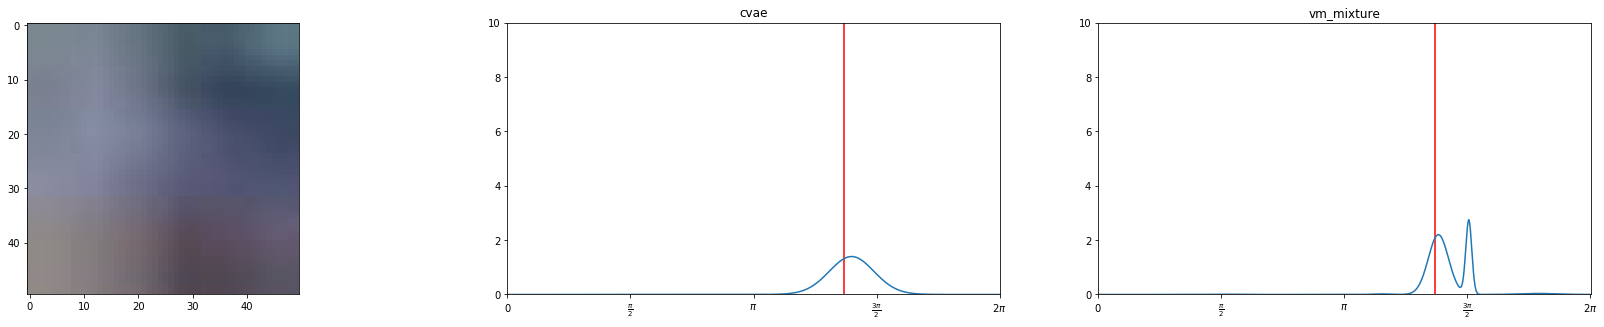

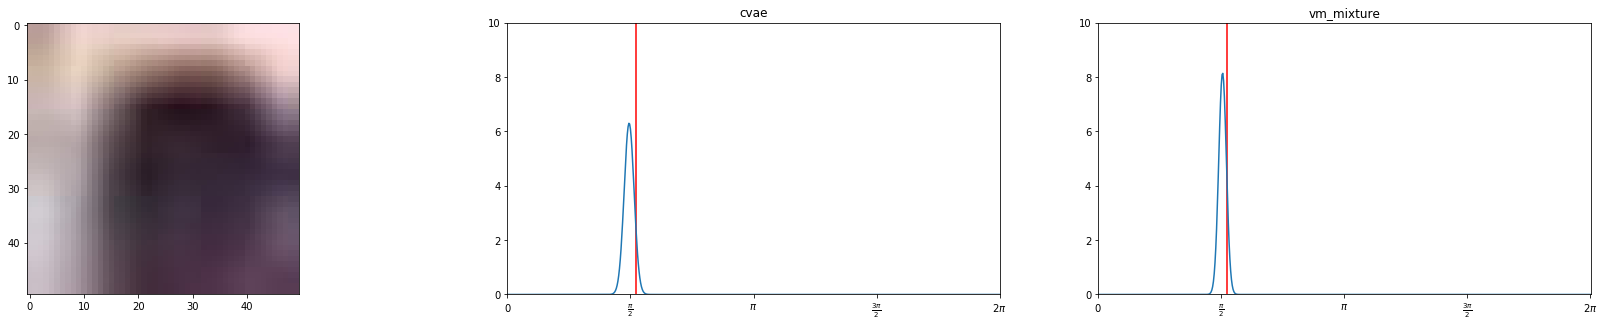

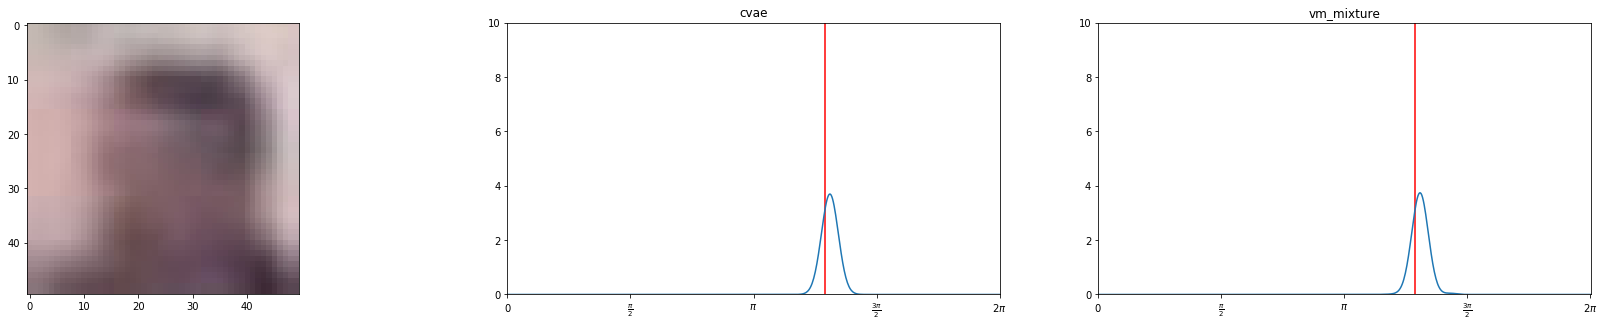

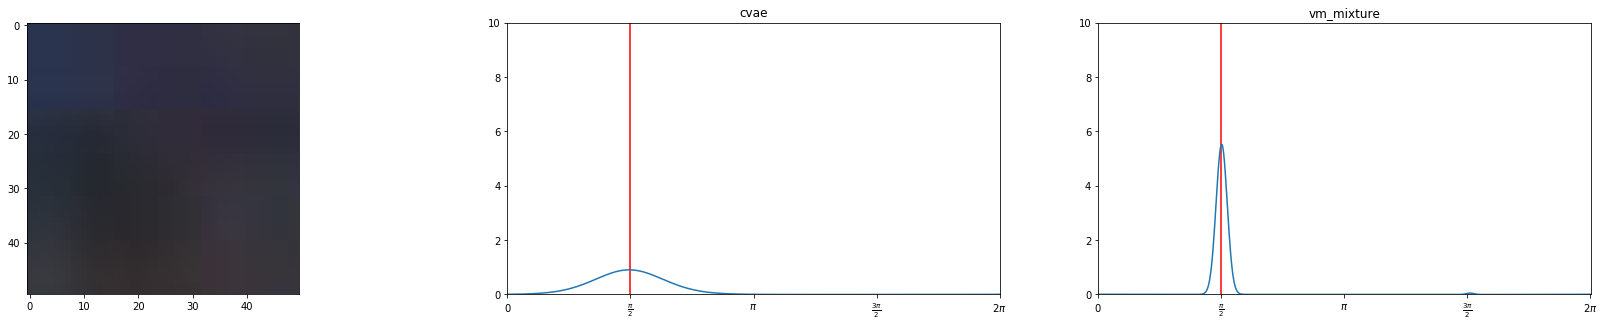

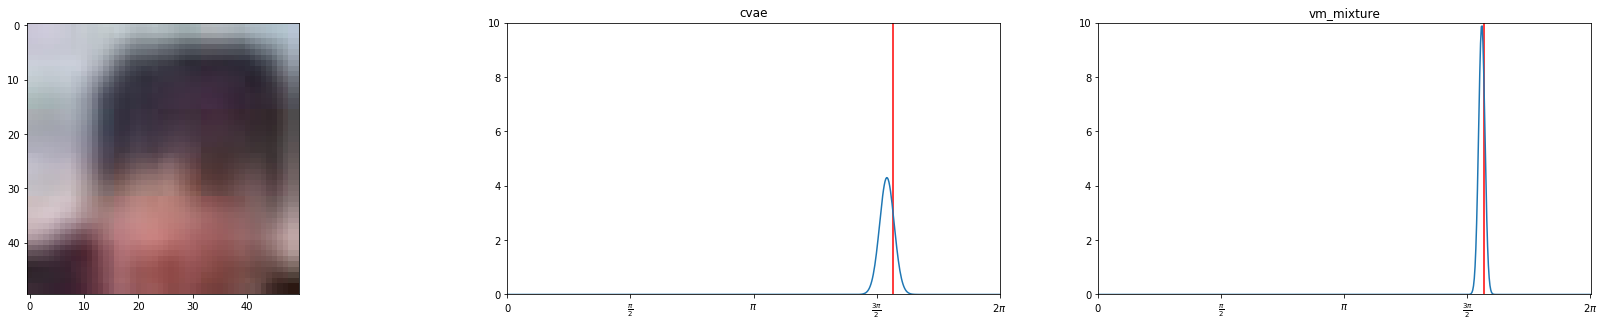

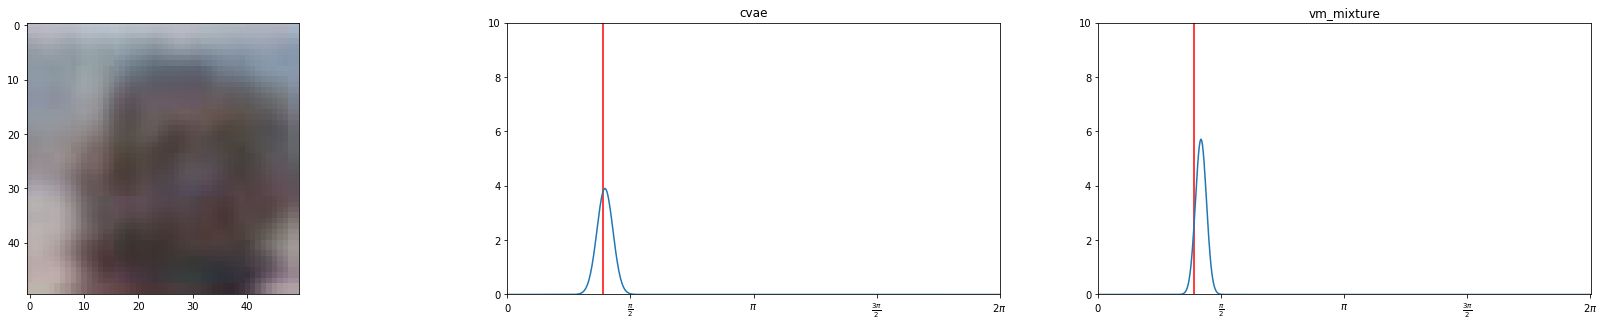

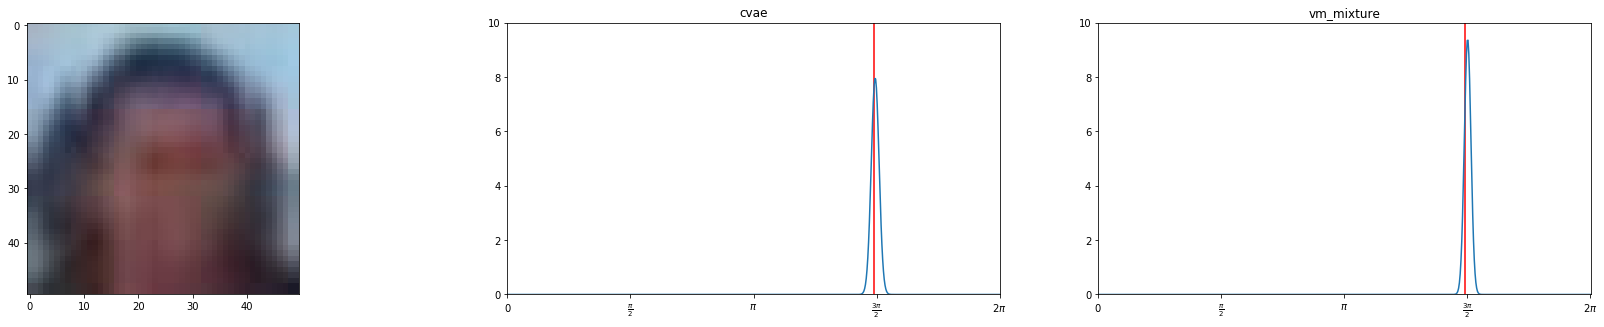

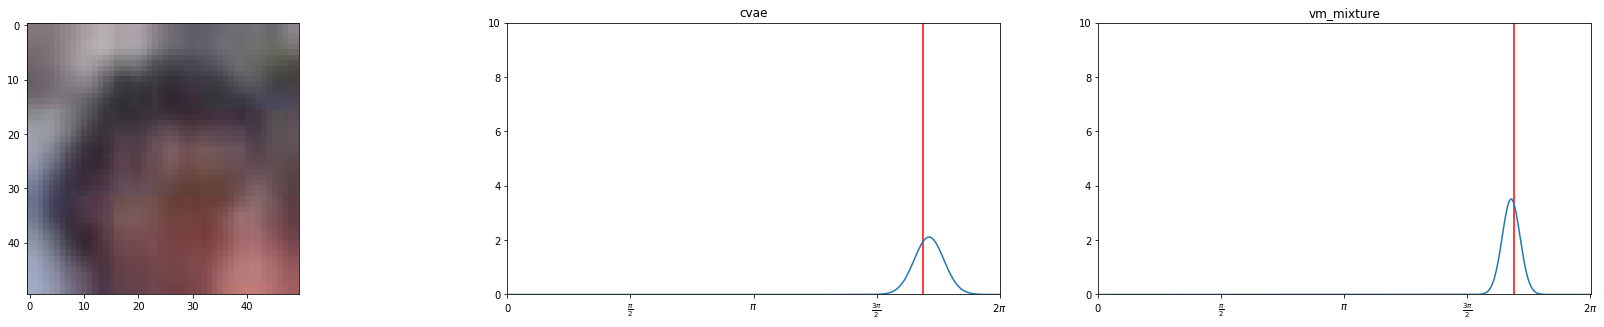

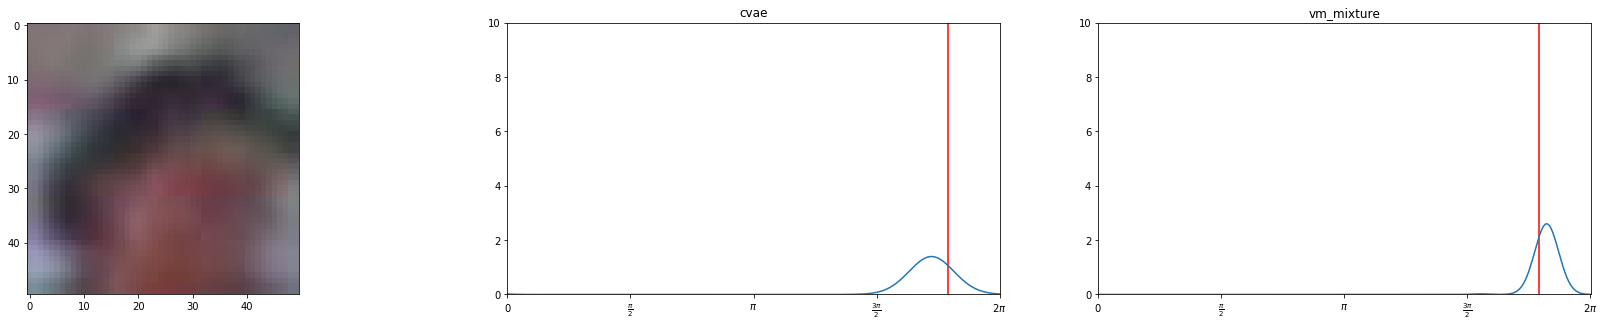

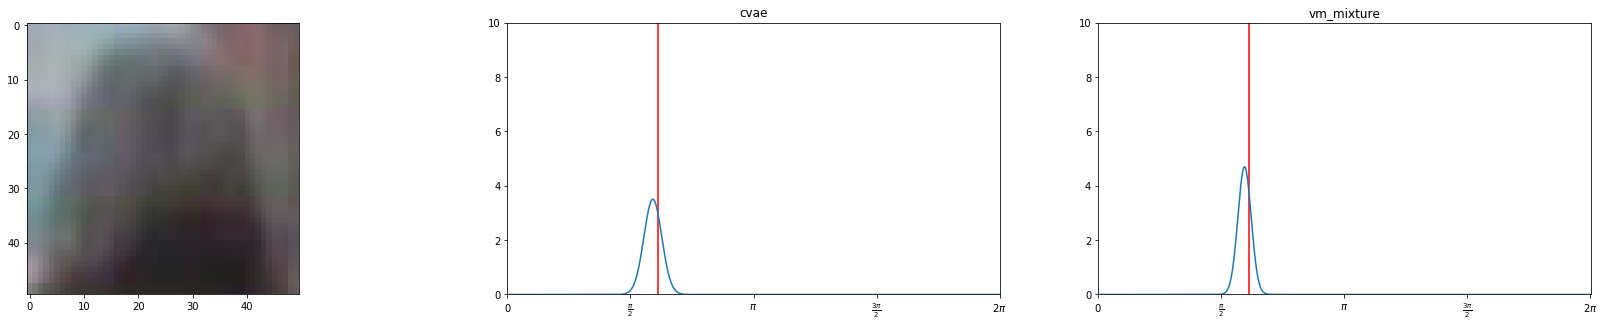

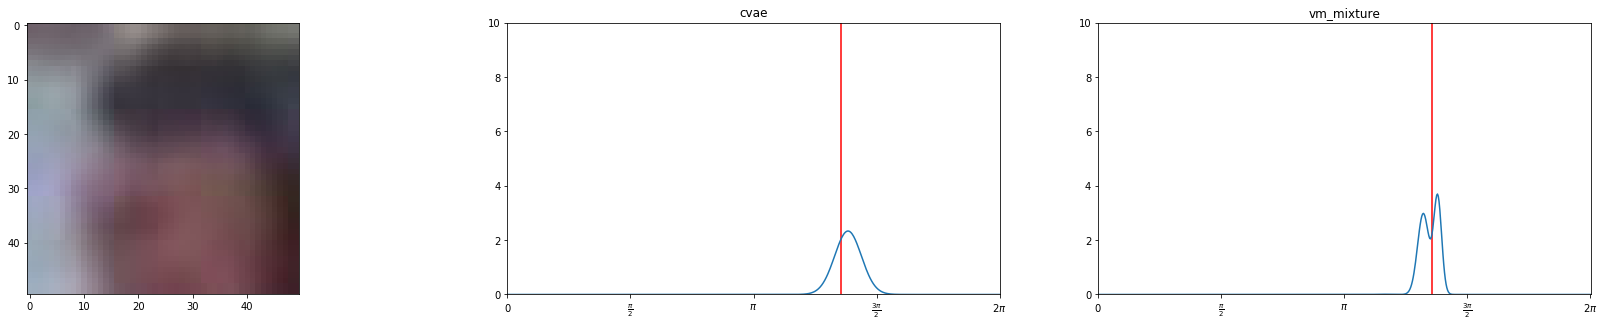

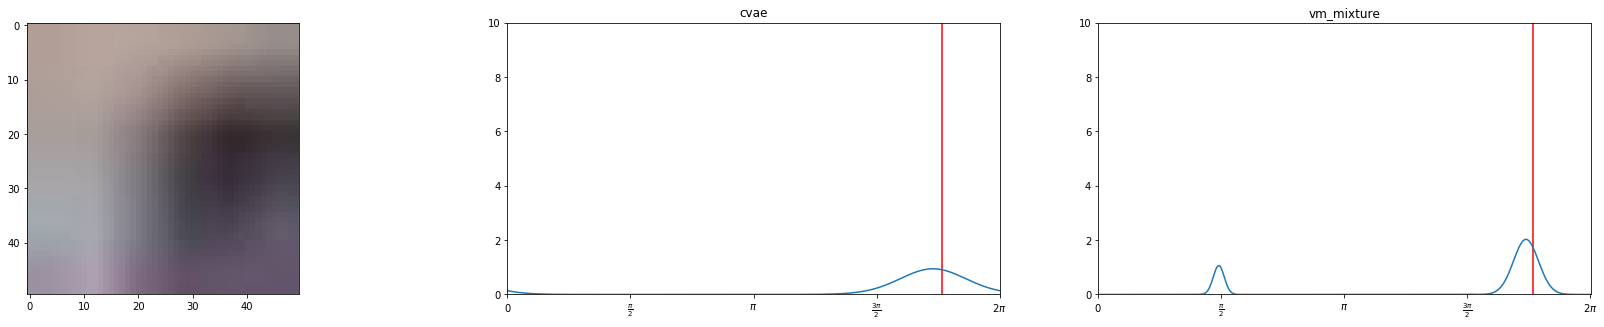

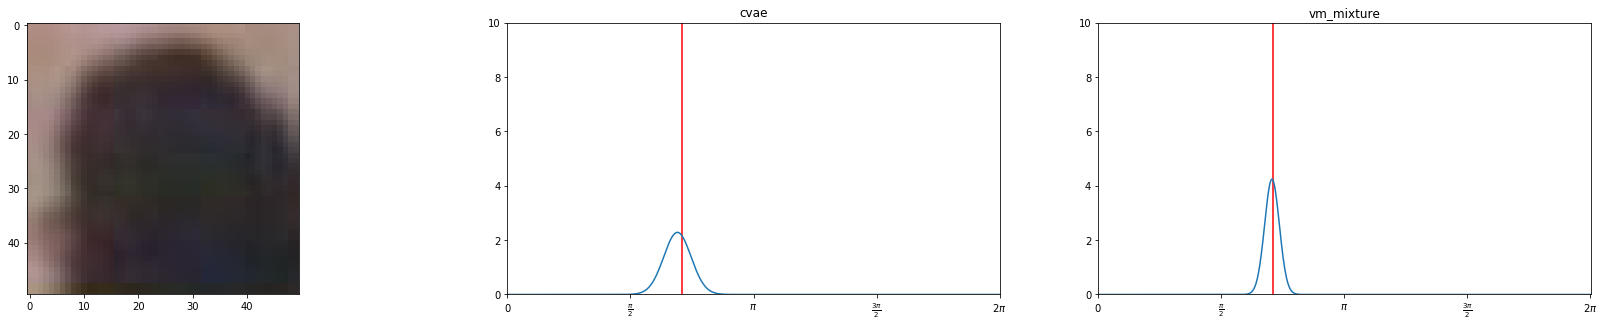

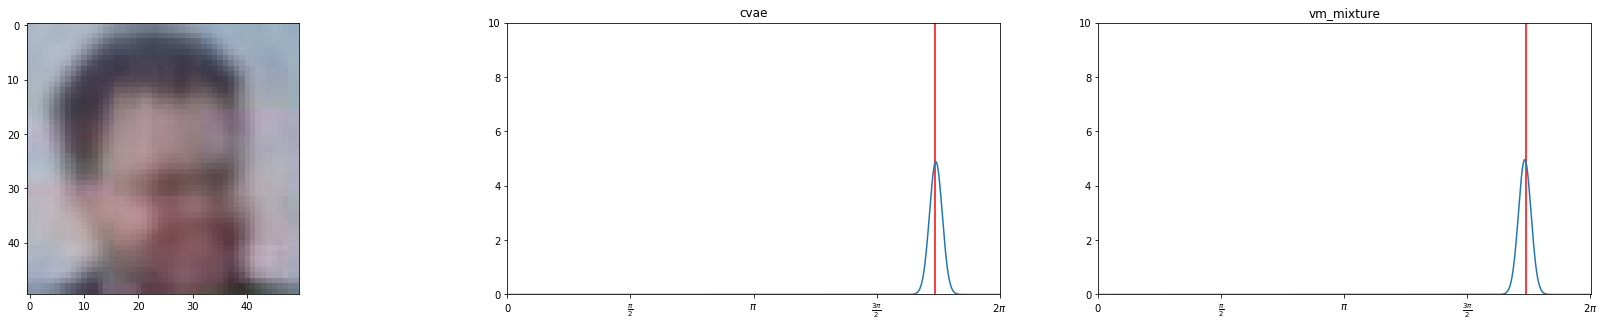

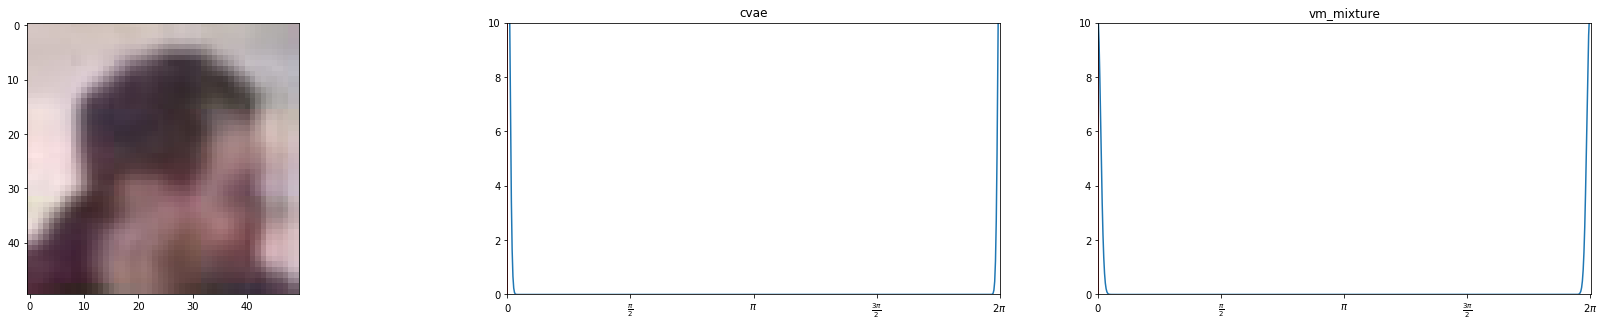

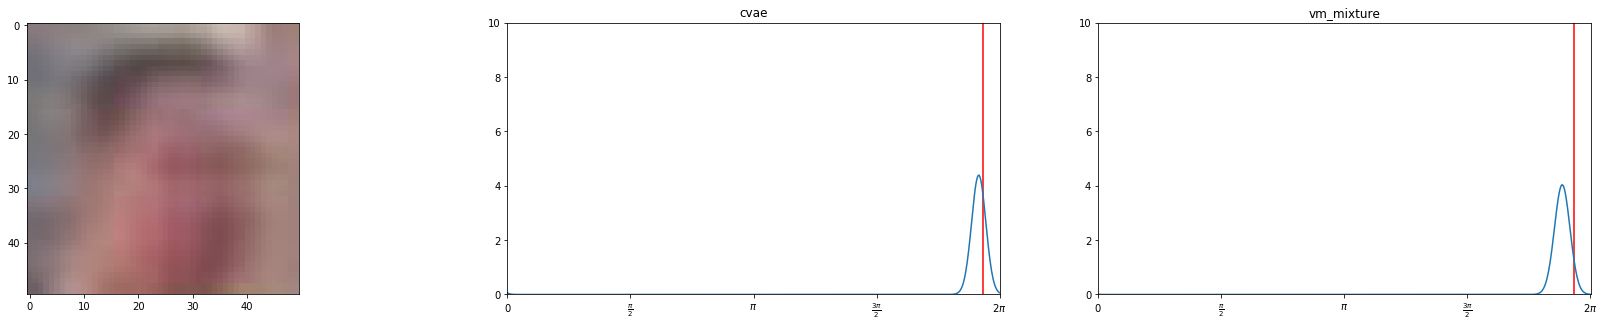

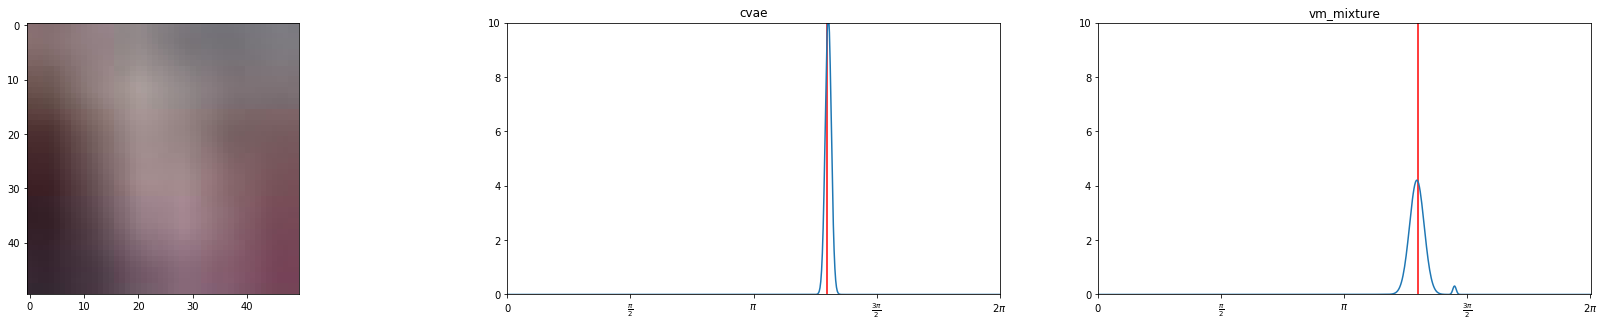

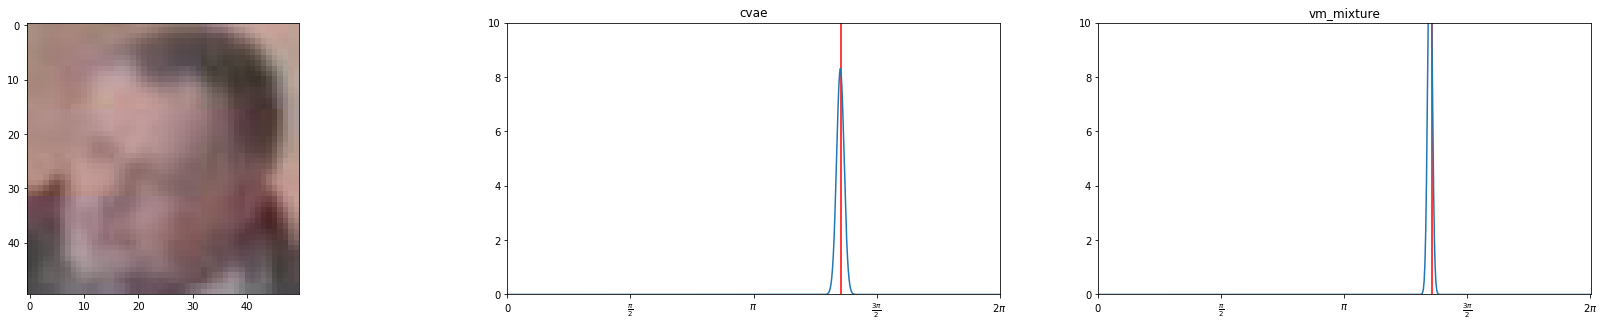

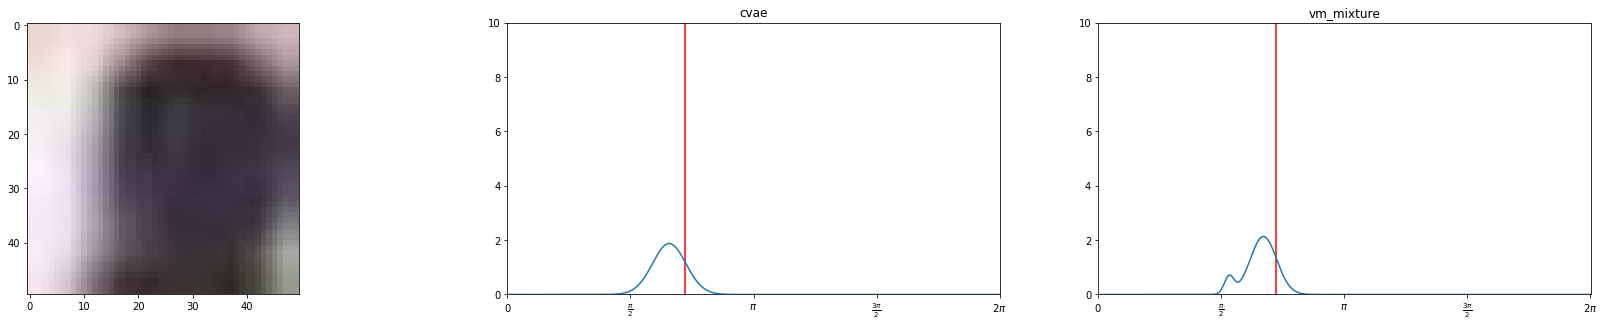

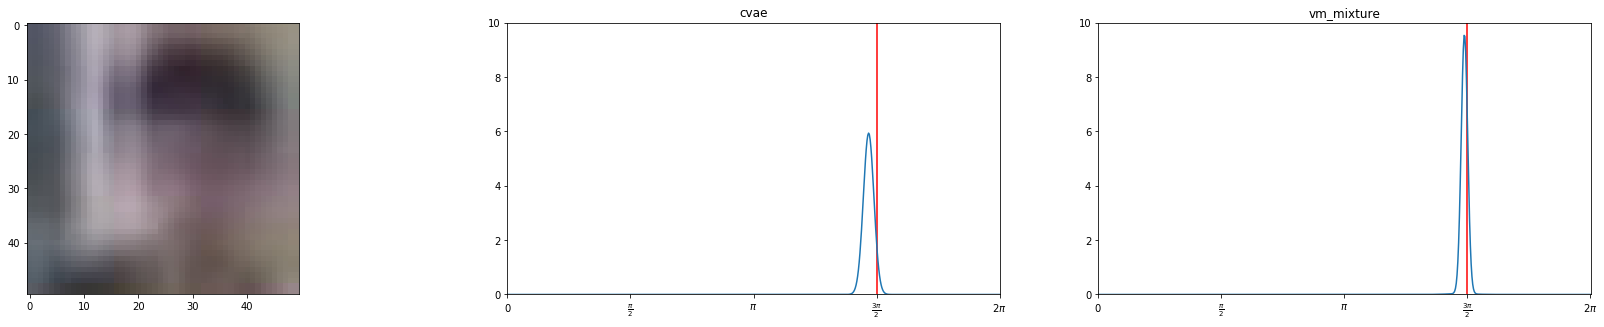

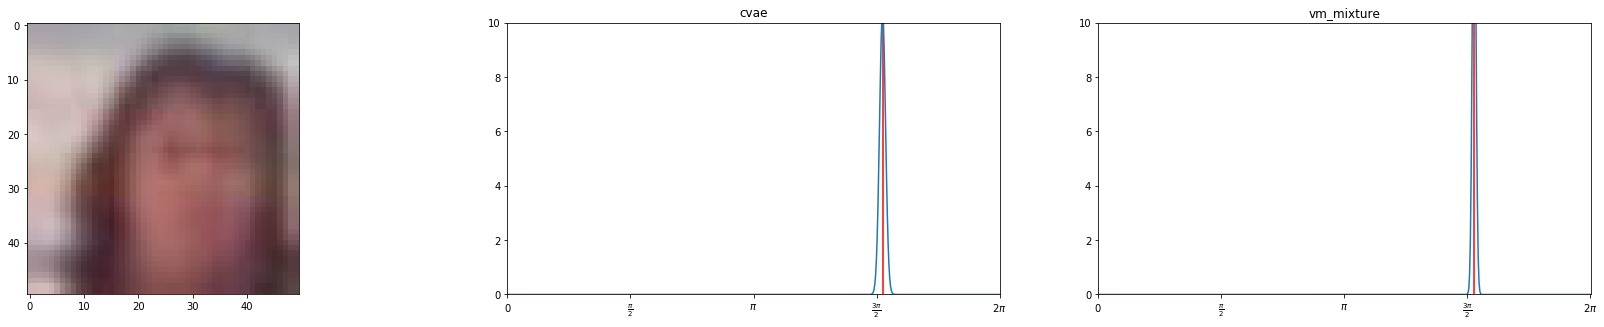

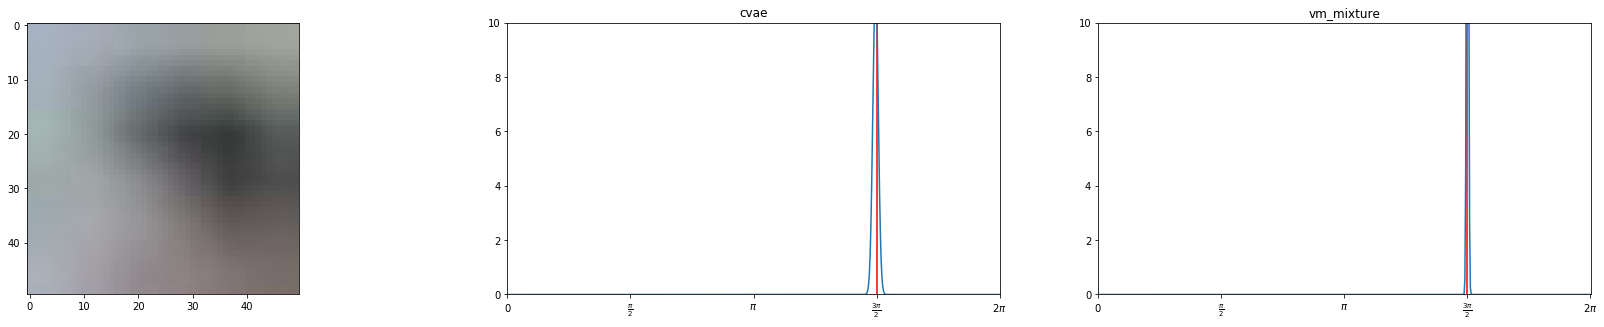

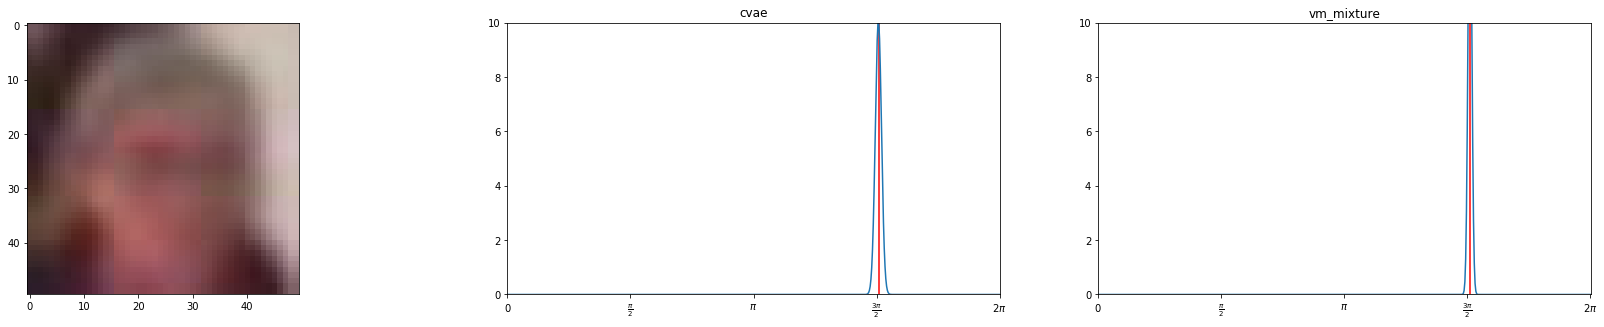

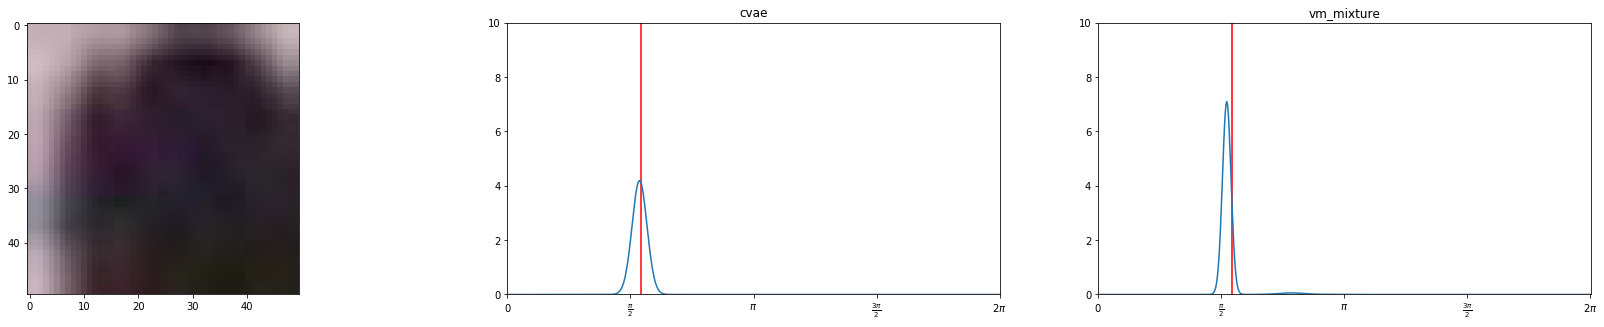

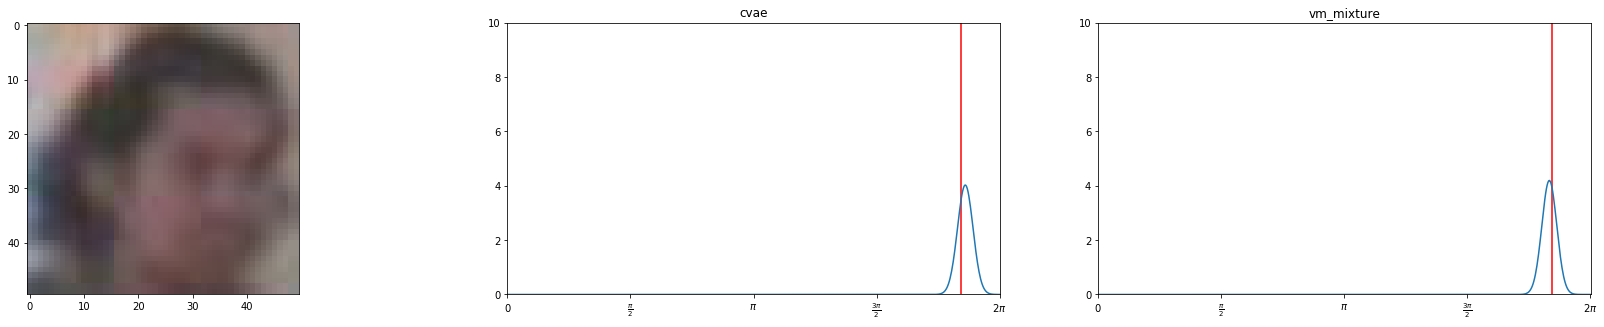

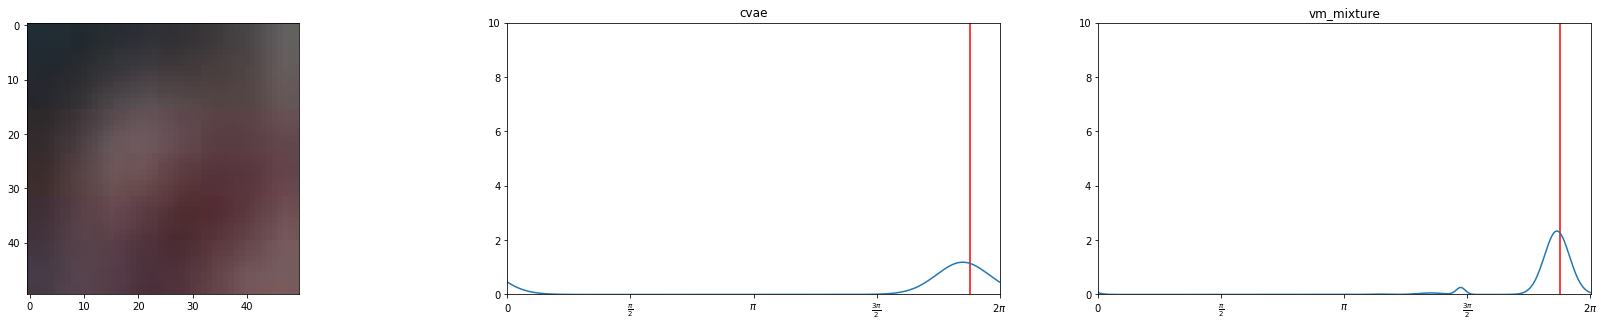

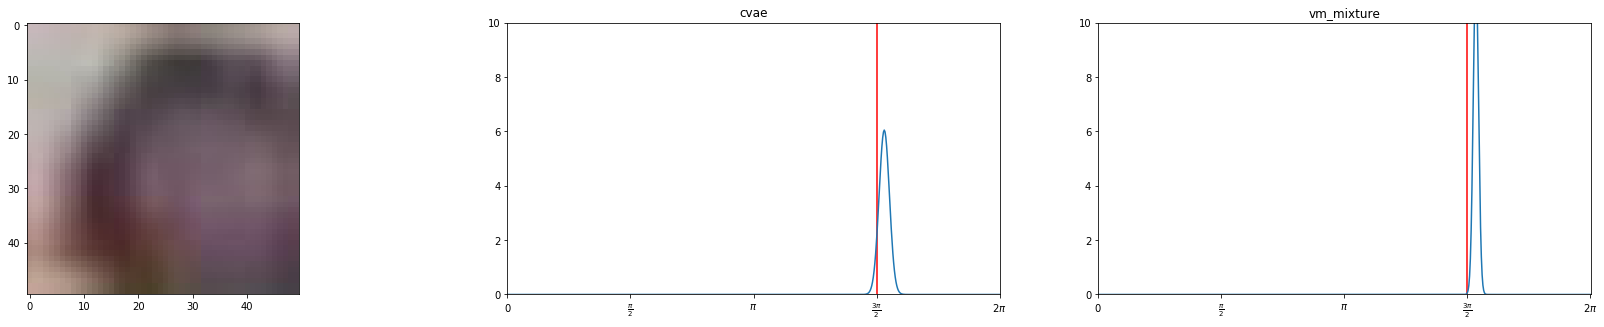

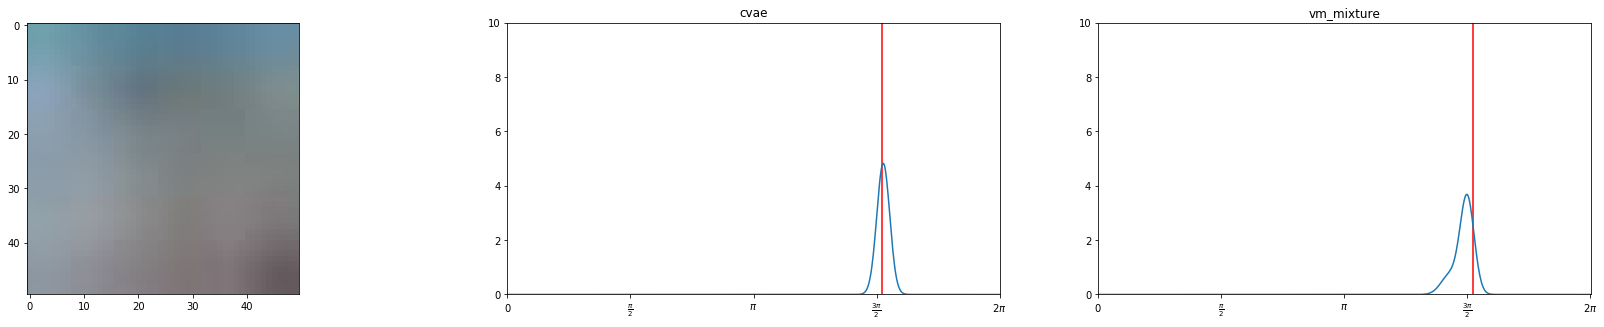

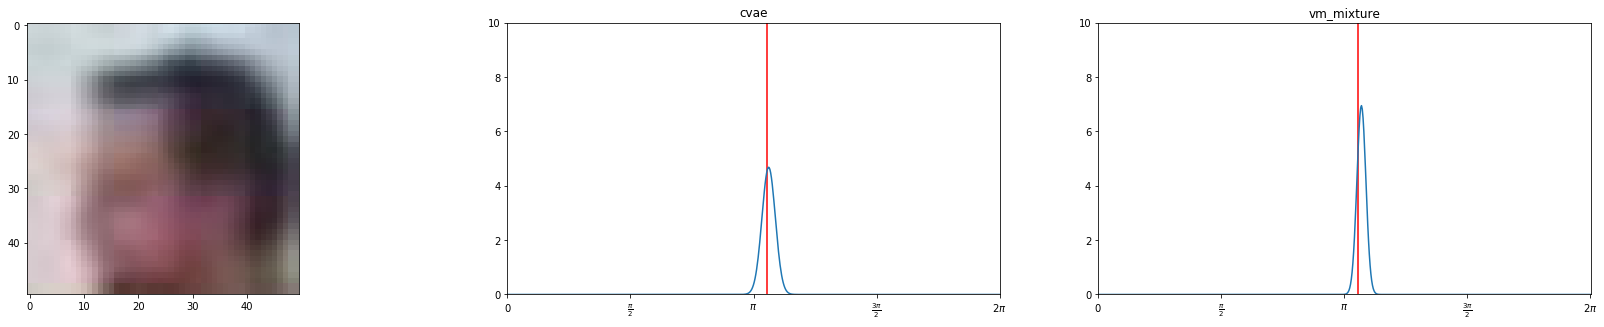

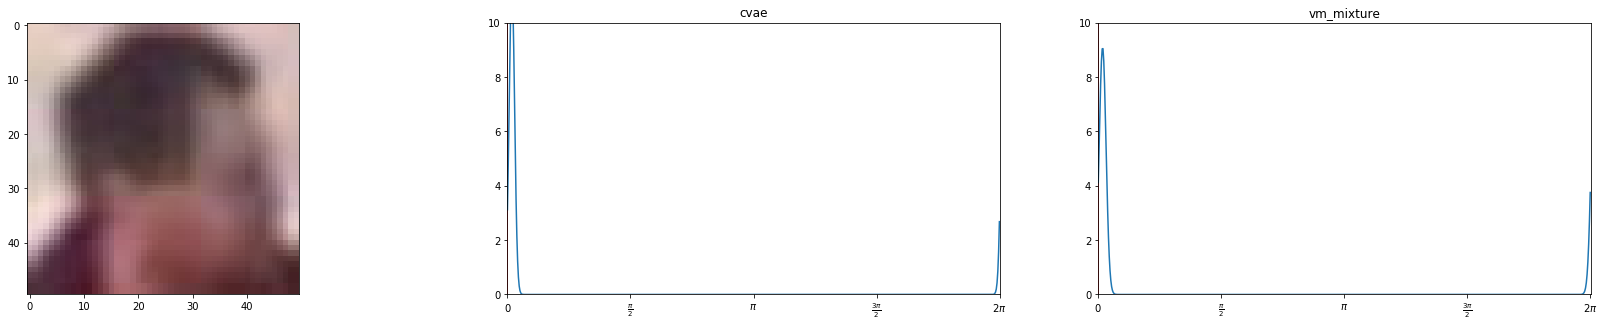

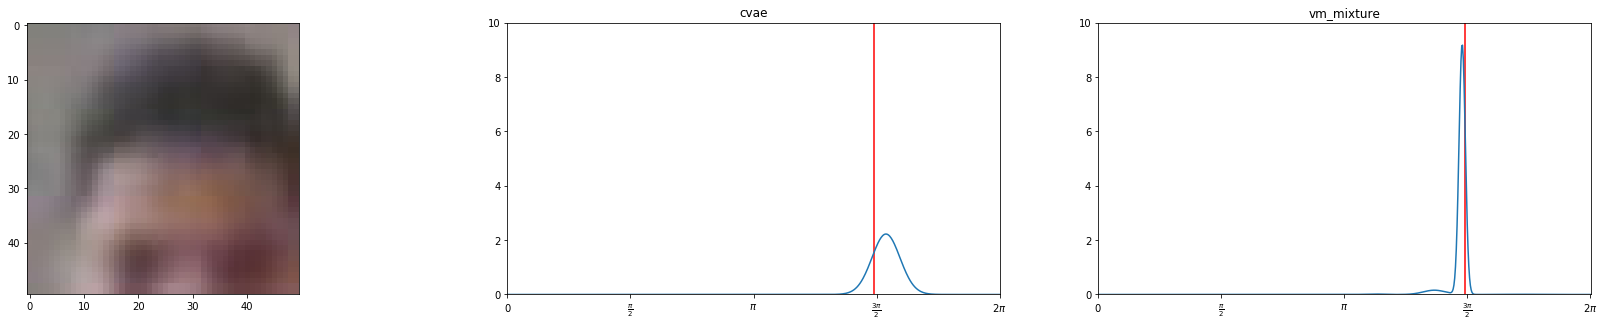

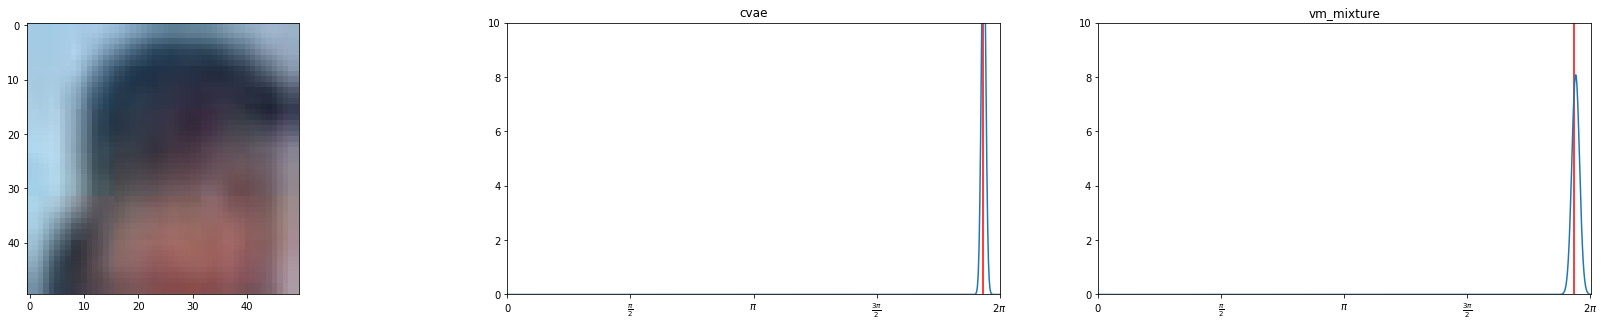

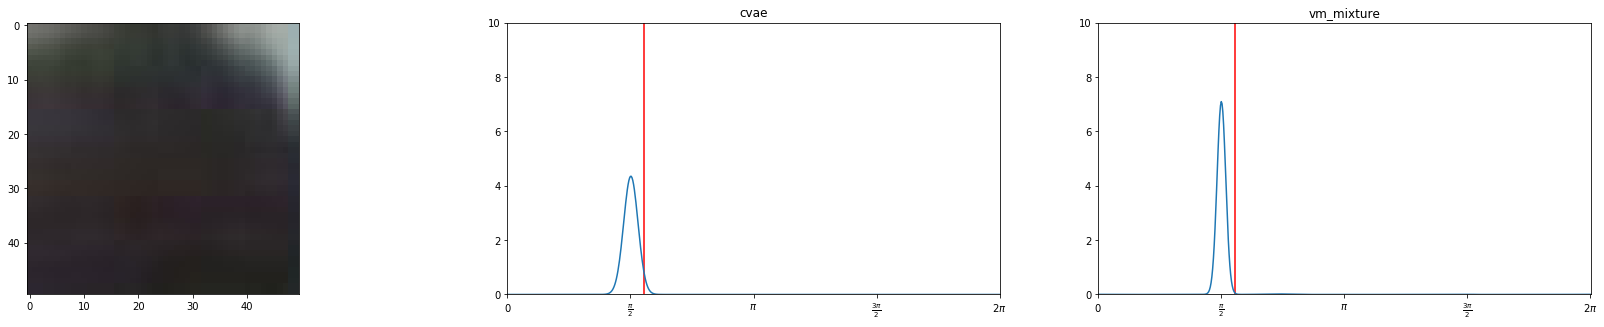

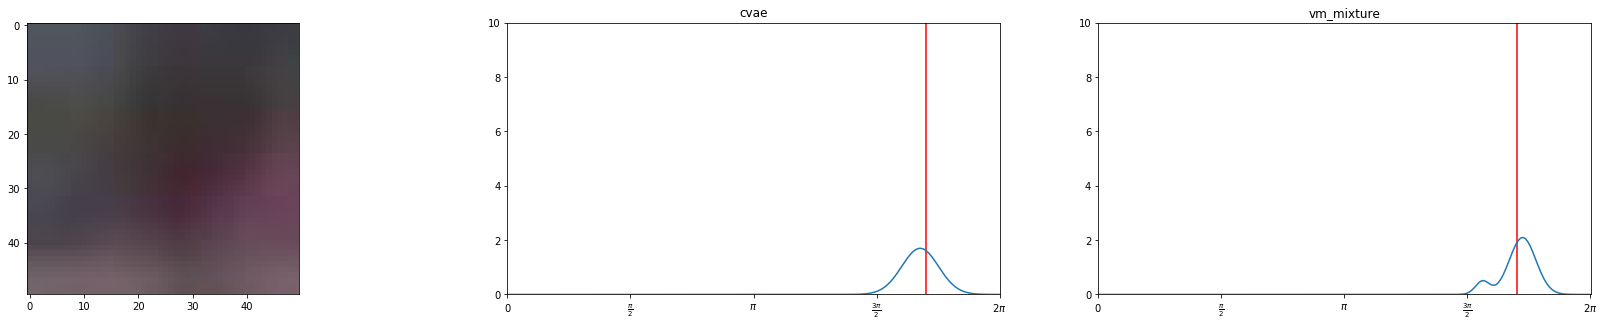

In [147]:
from utils.angles import bit2deg

yte_rad = np.deg2rad(bit2deg(yte_bit))

for fid in range(0, n_test_images):
    
    pdfs_dict = {}
    pdfs_dict['cvae'] = cvae_acc_pdfs[fid]
    pdfs_dict['vm_mixture'] = vmmix_acc_pdf[fid]
    #plot_image_results(xte[fid], xvals, cvae_acc_pdfs[fid], cvae_samples_pdfs[fid], yte_rad[fid])
    plot_image_results(xte[fid], xvals,  pdfs_dict, yte_rad[fid])